# ST3189 Machine Learning Coursework Project
# Predicting Bank Term Deposit Subscription

**Candidate Number:** 230573260  
**University of London — Singapore Institute of Management**

---

## Dataset: Bank Marketing Dataset (UCI Repository)

This project analyses the Bank Marketing dataset from the UCI Machine Learning Repository,
relating to direct marketing campaigns of a Portuguese banking institution (2008–2010).
The dataset has been widely studied in the machine learning literature, most notably by
Moro et al. (2014), who demonstrated that data-driven models could substantially improve
telemarketing targeting efficiency.

**Source:** https://archive.ics.uci.edu/ml/datasets/bank+marketing  
**Reference:** Moro, S., Cortez, P. & Rita, P. (2014). A data-driven approach to predict
the success of bank telemarketing. *Decision Support Systems*, 62, 22–31.

### Project Structure

| Section | Task | Key Question |
|---------|------|-------------|
| Task 1 | Unsupervised Learning | Can we identify distinct customer segments via PCA and clustering? |
| Task 2 | Regression | Is call duration predictable from customer characteristics? |
| Task 3 | Classification | Which models best predict term deposit subscription? |

### Key Methodological Principles
- Train-test split performed **before** any encoding or scaling (no data leakage)
- OneHotEncoder and StandardScaler fitted on **training data only**, then applied to both sets
- PR-AUC used alongside ROC-AUC for imbalanced data (11.3% positive class)
- Thresholds optimised via **cross-validation** (not on test set)
- Stratified 5-Fold Cross-Validation for robust model comparison
- Baseline models (DummyClassifier, DummyRegressor) establish performance floors
- Class imbalance addressed at both training (class weighting) and evaluation stages


In [1]:
# Environment note:
# Install dependencies once outside the notebook for reproducibility, e.g.:
#   pip install -r requirements.txt
# This notebook assumes dependencies are already installed.


## 1. Setup and Data Loading

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                      cross_val_score, cross_val_predict,
                                      GridSearchCV)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor

# Regression models
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV,
                                   Lasso, LassoCV, ElasticNet, ElasticNetCV,
                                   BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                               StackingRegressor)

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                            QuadraticDiscriminantAnalysis)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               AdaBoostClassifier, StackingClassifier)
from sklearn.neural_network import MLPRegressor, MLPClassifier
from xgboost import XGBRegressor, XGBClassifier

# Unsupervised
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                              roc_auc_score, roc_curve, average_precision_score,
                              precision_recall_curve, f1_score, precision_score,
                              recall_score, mean_squared_error, r2_score,
                              mean_absolute_error, silhouette_score,
                              adjusted_rand_score, make_scorer)
from scipy.stats import skew
import warnings

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully.")
print("Python package versions")
print(f"pandas={pd.__version__}, numpy={np.__version__}, sklearn={__import__('sklearn').__version__}")


All libraries imported successfully.
Python package versions
pandas=2.2.3, numpy=2.1.3, sklearn=1.6.1


In [3]:
# Load the dataset (robust download with timeout)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

import zipfile, io, urllib.request

try:
    response = urllib.request.urlopen(url, timeout=30)
    zip_file = zipfile.ZipFile(io.BytesIO(response.read()))
    df = pd.read_csv(zip_file.open('bank-additional/bank-additional-full.csv'), sep=';')
except Exception as e:
    raise RuntimeError("Failed to download/read dataset from UCI. Check internet access or mirror URL.") from e

print(f"Dataset shape: {df.shape}")
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")


Dataset shape: (41188, 21)
Number of observations: 41188
Number of features: 21


## 2. Exploratory Data Analysis

In [4]:
# First look at the data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# Descriptive statistics for numerical variables
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# Check for missing values
# This dataset uses 'unknown' rather than NaN for missing data
missing_values = df.isnull().sum()
print("Missing values (NaN):", missing_values.sum())
print("\n'Unknown' values per categorical column:")
for col in df.select_dtypes(include='object').columns:
    n_unknown = (df[col] == 'unknown').sum()
    if n_unknown > 0:
        print(f"  {col}: {n_unknown} ({n_unknown/len(df)*100:.1f}%)")
print("\nDecision: Retain 'unknown' as a separate category (not imputed).")

Missing values (NaN): 0

'Unknown' values per categorical column:
  job: 330 (0.8%)
  marital: 80 (0.2%)
  education: 1731 (4.2%)
  default: 8597 (20.9%)
  housing: 990 (2.4%)
  loan: 990 (2.4%)

Decision: Retain 'unknown' as a separate category (not imputed).


Target variable (y) distribution:
y
no     36548
yes     4640
Name: count, dtype: int64

Positive class rate: 11.27%

--> Severe class imbalance: only ~11% subscribed.
    A naive 'always predict no' classifier gets ~89% accuracy,
    so accuracy alone is MISLEADING. We need PR-AUC and F1.


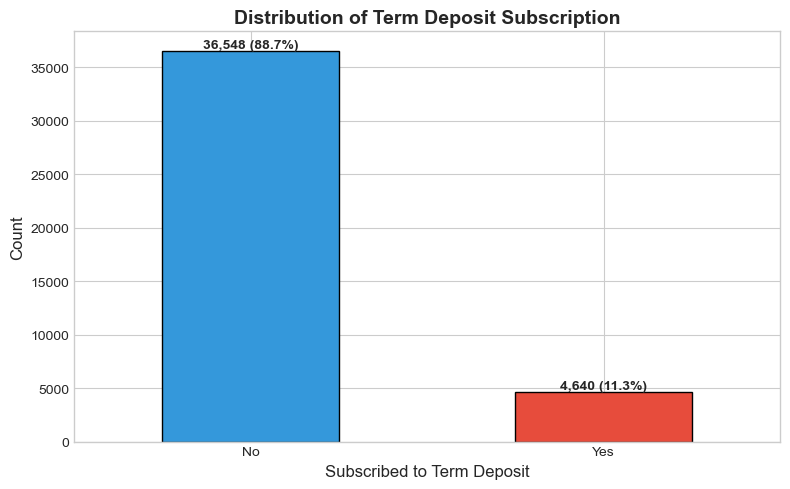

In [8]:
# Target variable distribution
print("Target variable (y) distribution:")
print(df['y'].value_counts())
print(f"\nPositive class rate: {(df['y'] == 'yes').mean() * 100:.2f}%")
print("\n--> Severe class imbalance: only ~11% subscribed.")
print("    A naive 'always predict no' classifier gets ~89% accuracy,")
print("    so accuracy alone is MISLEADING. We need PR-AUC and F1.")

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#3498db', '#e74c3c']
counts = df['y'].value_counts()
counts.plot(kind='bar', color=colors, edgecolor='black', ax=ax)
ax.set_title('Distribution of Term Deposit Subscription', fontsize=14, fontweight='bold')
ax.set_xlabel('Subscribed to Term Deposit', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['No', 'Yes'], rotation=0)
for i, v in enumerate(counts.values):
    ax.text(i, v + 300, f'{v:,} ({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

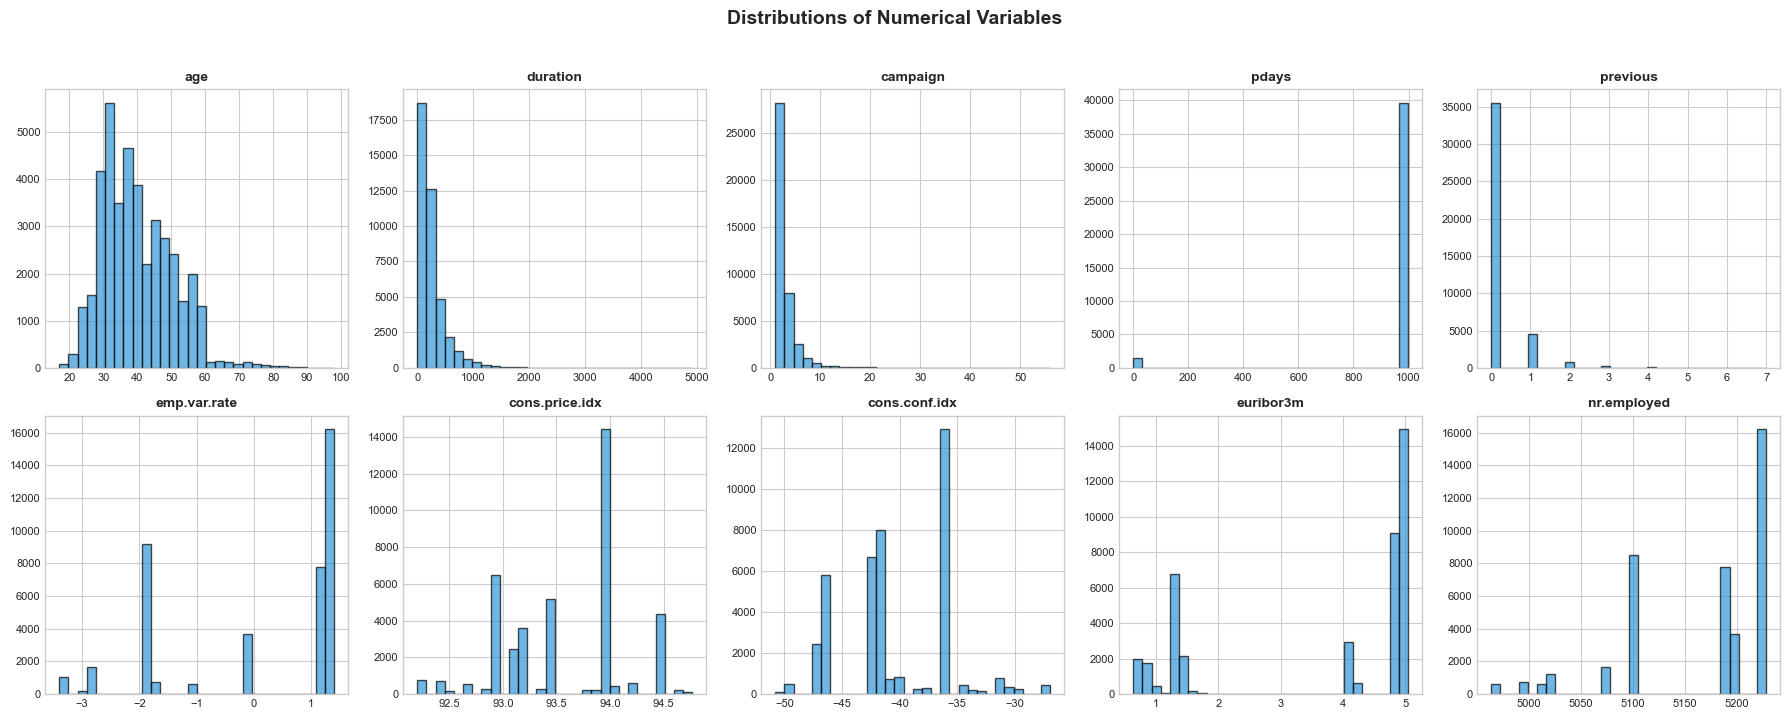

Key observations:
- 'duration' is right-skewed (many short calls, few very long ones)
- 'pdays' has a spike at 999 (client not previously contacted)
- Economic indicators cluster around distinct periods (2008 crisis context)


In [9]:
# Distribution of numerical variables
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
for i, col in enumerate(numerical_cols):
    ax = axes[i // 5, i % 5]
    ax.hist(df[col], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.tick_params(labelsize=8)
plt.suptitle('Distributions of Numerical Variables', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Key observations:")
print("- 'duration' is right-skewed (many short calls, few very long ones)")
print("- 'pdays' has a spike at 999 (client not previously contacted)")
print("- Economic indicators cluster around distinct periods (2008 crisis context)")

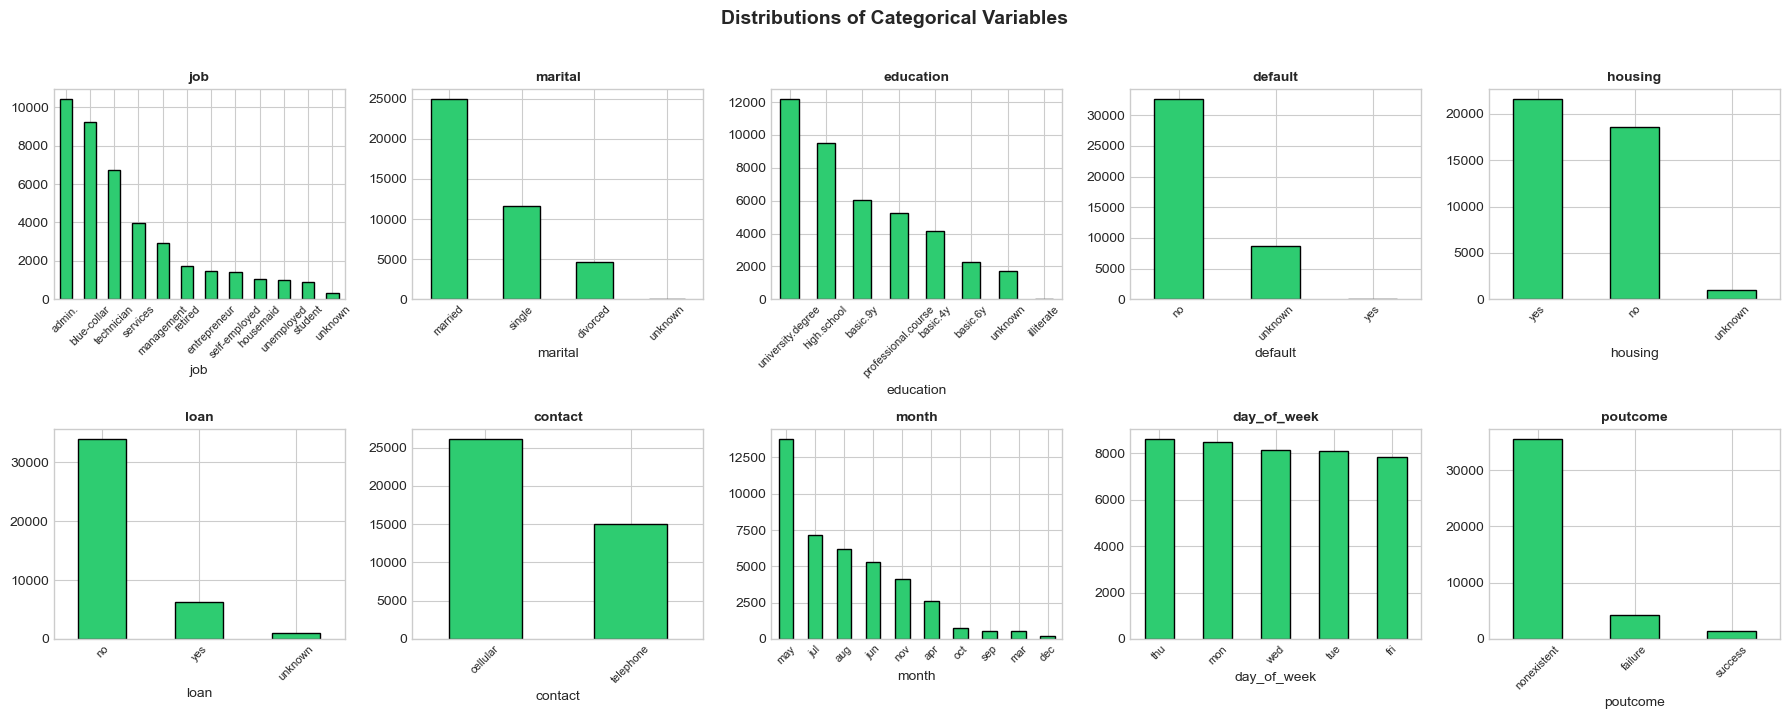

In [10]:
# Categorical variables distribution
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
for i, col in enumerate(categorical_cols):
    ax = axes[i // 5, i % 5]
    df[col].value_counts().plot(kind='bar', ax=ax, color='#2ecc71', edgecolor='black')
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.suptitle('Distributions of Categorical Variables', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

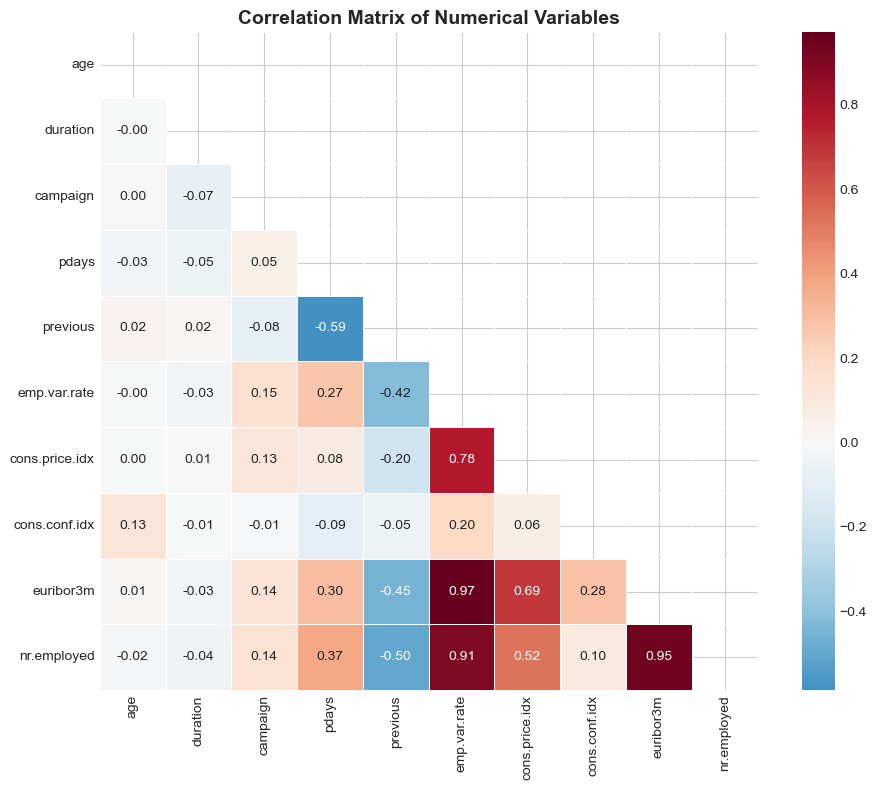

Notable correlations:
- euribor3m & emp.var.rate: r ~ 0.97 (both track economic conditions)
- nr.employed & euribor3m: r ~ 0.95 (macro indicators move together)
- duration has LOW correlation with other features --> hard to predict


In [11]:
# Correlation heatmap for numerical variables
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = df[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Notable correlations:")
print("- euribor3m & emp.var.rate: r ~ 0.97 (both track economic conditions)")
print("- nr.employed & euribor3m: r ~ 0.95 (macro indicators move together)")
print("- duration has LOW correlation with other features --> hard to predict")

## 3. Data Preprocessing and Train-Test Split

**Critical methodological point:** We split the data *before* any encoding or scaling to
prevent data leakage. Both the OneHotEncoder and StandardScaler are fitted on training
data only, then applied to both sets. This ensures test set performance estimates are
unbiased (James et al., 2021, Ch. 5).

Steps:
1. Encode target variable
2. **Split into train/test (80/20, stratified)**
3. **Fit OneHotEncoder on training data ONLY** → transform both sets
4. **Fit StandardScaler on training data ONLY** → transform both sets


In [12]:
# Step 1: Encode target variable
df_processed = df.copy()
df_processed['y_encoded'] = (df_processed['y'] == 'yes').astype(int)
print("Target encoding: 'yes' = 1, 'no' = 0")

# Step 2: Define features and target (NO encoding yet -- split first)
X = df_processed.drop(['y', 'y_encoded'], axis=1)
y = df_processed['y_encoded']

categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                  'euribor3m', 'nr.employed']

print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"Categorical: {len(categorical_cols)}, Numerical: {len(numerical_cols)}")


Target encoding: 'yes' = 1, 'no' = 0
Features: 20, Samples: 41188
Categorical: 10, Numerical: 10


In [13]:
# ======================================================================
# Step 3: SPLIT FIRST -- before ANY preprocessing (CRITICAL)
# ======================================================================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train_raw.shape[0]} samples")
print(f"Test set:     {X_test_raw.shape[0]} samples")
print(f"\nClass distribution preserved by stratification:")
print(f"  Train positive rate: {y_train.mean()*100:.1f}%")
print(f"  Test positive rate:  {y_test.mean()*100:.1f}%")

# ======================================================================
# Step 4: OneHotEncoder fitted on TRAINING data only
# ======================================================================
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist')
ohe.fit(X_train_raw[categorical_cols])

# Transform both sets
train_cat = pd.DataFrame(ohe.transform(X_train_raw[categorical_cols]),
                         columns=ohe.get_feature_names_out(categorical_cols),
                         index=X_train_raw.index)
test_cat = pd.DataFrame(ohe.transform(X_test_raw[categorical_cols]),
                        columns=ohe.get_feature_names_out(categorical_cols),
                        index=X_test_raw.index)

# Combine numerical + encoded categorical
X_train_unscaled = pd.concat([X_train_raw[numerical_cols], train_cat], axis=1)
X_test_unscaled = pd.concat([X_test_raw[numerical_cols], test_cat], axis=1)

print(f"\n[OK] OneHotEncoder fitted on training data only -- no data leakage")
print(f"Shape after encoding: train={X_train_unscaled.shape}, test={X_test_unscaled.shape}")

# ======================================================================
# Step 5: StandardScaler fitted on TRAINING data only (numerical cols)
# ======================================================================
scaler = StandardScaler()
X_train = X_train_unscaled.copy()
X_test = X_test_unscaled.copy()

X_train[numerical_cols] = scaler.fit_transform(X_train_unscaled[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test_unscaled[numerical_cols])

print(f"[OK] StandardScaler fitted on training data only -- no data leakage")


Training set: 32950 samples
Test set:     8238 samples

Class distribution preserved by stratification:
  Train positive rate: 11.3%
  Test positive rate:  11.3%

[OK] OneHotEncoder fitted on training data only -- no data leakage
Shape after encoding: train=(32950, 53), test=(8238, 53)
[OK] StandardScaler fitted on training data only -- no data leakage


In [14]:
# Step 6: Create feature sets for different tasks

# Pre-call features: EXCLUDE duration (unknown before call)
X_train_precall = X_train.drop('duration', axis=1)
X_test_precall = X_test.drop('duration', axis=1)

# Regression features and target (predict duration from other features)
X_train_reg = X_train.drop('duration', axis=1)
X_test_reg = X_test.drop('duration', axis=1)
y_train_reg = X_train_unscaled['duration'].copy()  # unscaled duration as target
y_test_reg = X_test_unscaled['duration'].copy()

print("Feature sets prepared:")
print(f"  Real-time (with duration):   {X_train.shape[1]} features")
print(f"  Pre-call (without duration): {X_train_precall.shape[1]} features")
print(f"  Regression target: mean = {y_train_reg.mean():.1f}s, median = {y_train_reg.median():.1f}s")


Feature sets prepared:
  Real-time (with duration):   53 features
  Pre-call (without duration): 52 features
  Regression target: mean = 258.1s, median = 180.0s


---

## TASK 1: UNSUPERVISED LEARNING

### Objective
Identify distinct customer segments using dimensionality reduction (PCA) and clustering
(K-Means, Hierarchical). Explore whether these segments show different subscription
behaviours and whether cluster membership can enhance classification.

**Note:** PCA and clustering are fitted on the **training set only** to prevent information
leakage when cluster labels are later used as classification features.

### 1.1 Principal Component Analysis (PCA)

In [15]:
# PCA -- fitted on TRAINING data only
pca = PCA(random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Variance explained
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print("Variance explained by first 10 components:")
for i in range(10):
    print(f"  PC{i+1}: {variance_explained[i]*100:.2f}% (Cumulative: {cumulative_variance[i]*100:.2f}%)")

n_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_90}")

Variance explained by first 10 components:
  PC1: 28.44% (Cumulative: 28.44%)
  PC2: 10.03% (Cumulative: 38.46%)
  PC3: 8.17% (Cumulative: 46.63%)
  PC4: 7.47% (Cumulative: 54.10%)
  PC5: 6.80% (Cumulative: 60.90%)
  PC6: 6.24% (Cumulative: 67.14%)
  PC7: 4.06% (Cumulative: 71.20%)
  PC8: 2.92% (Cumulative: 74.12%)
  PC9: 2.56% (Cumulative: 76.68%)
  PC10: 1.98% (Cumulative: 78.66%)

Components needed for 90% variance: 18


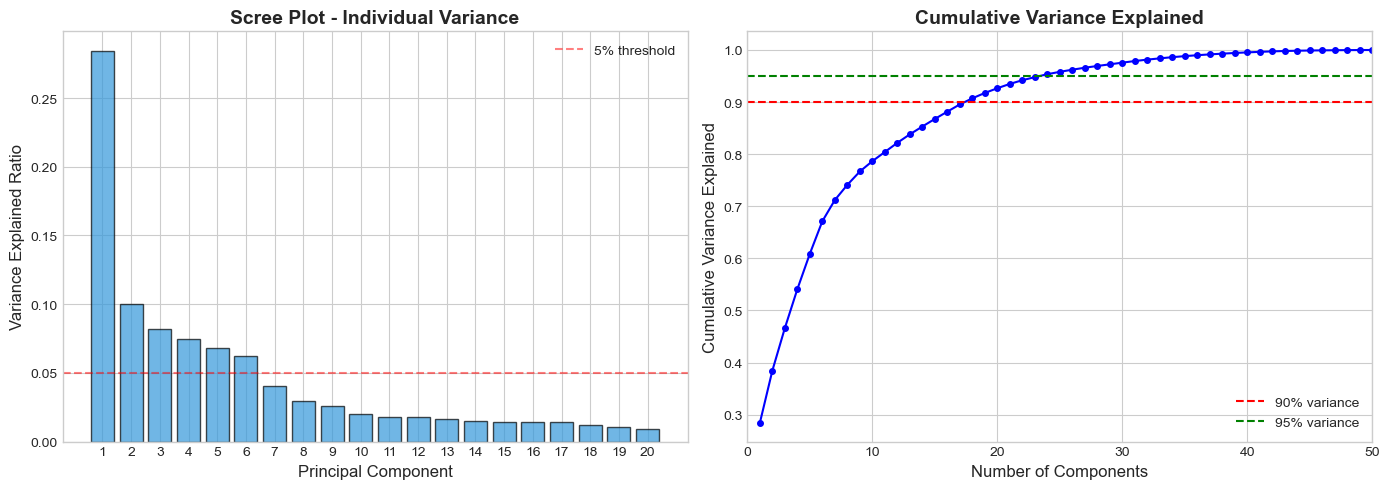

In [16]:
# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, 21), variance_explained[:20],
            color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained Ratio', fontsize=12)
axes[0].set_title('Scree Plot - Individual Variance', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 21))
axes[0].axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='5% threshold')
axes[0].legend()

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-o', markersize=4)
axes[1].axhline(y=0.90, color='r', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, 50)

plt.tight_layout()
plt.show()

### 1.2 PCA Component Interpretation

Examining feature loadings reveals what each component represents.

In [17]:
# PCA Loadings Analysis
loadings = pd.DataFrame(
    pca.components_.T[:, :5],
    index=X_train.columns,
    columns=[f'PC{i+1}' for i in range(5)]
)

print("Top Feature Contributions to Principal Components:")
print("=" * 65)
for pc in ['PC1', 'PC2', 'PC3']:
    pc_idx = int(pc[2]) - 1
    print(f"\n{pc} (explains {variance_explained[pc_idx]*100:.1f}% variance):")
    top_pos = loadings[pc].nlargest(3)
    top_neg = loadings[pc].nsmallest(3)
    print("  Positive loadings:")
    for feat, val in top_pos.items():
        print(f"    {feat:30s}: {val:+.3f}")
    print("  Negative loadings:")
    for feat, val in top_neg.items():
        print(f"    {feat:30s}: {val:+.3f}")

print("\n" + "=" * 65)
print("INTERPRETATION:")
print("  PC1 = 'Economic Environment' (euribor3m, emp.var.rate, nr.employed)")
print("  PC2 = 'Customer Engagement'  (duration, campaign contacts)")
print("  PC3 = 'Demographics'         (age, job type, education)")
print("\nThe dominance of economic indicators in PC1 reflects the dataset")
print("spanning the 2008 financial crisis period (Moro et al., 2014).")

Top Feature Contributions to Principal Components:

PC1 (explains 28.4% variance):
  Positive loadings:
    euribor3m                     : +0.480
    emp.var.rate                  : +0.478
    nr.employed                   : +0.460
  Negative loadings:
    previous                      : -0.306
    poutcome_success              : -0.038
    marital_single                : -0.027

PC2 (explains 10.0% variance):
  Positive loadings:
    pdays                         : +0.605
    poutcome_nonexistent          : +0.115
    marital_single                : +0.055
  Negative loadings:
    previous                      : -0.462
    cons.conf.idx                 : -0.423
    cons.price.idx                : -0.275

PC3 (explains 8.2% variance):
  Positive loadings:
    age                           : +0.678
    cons.conf.idx                 : +0.435
    pdays                         : +0.248
  Negative loadings:
    cons.price.idx                : -0.294
    previous                      : -0.2

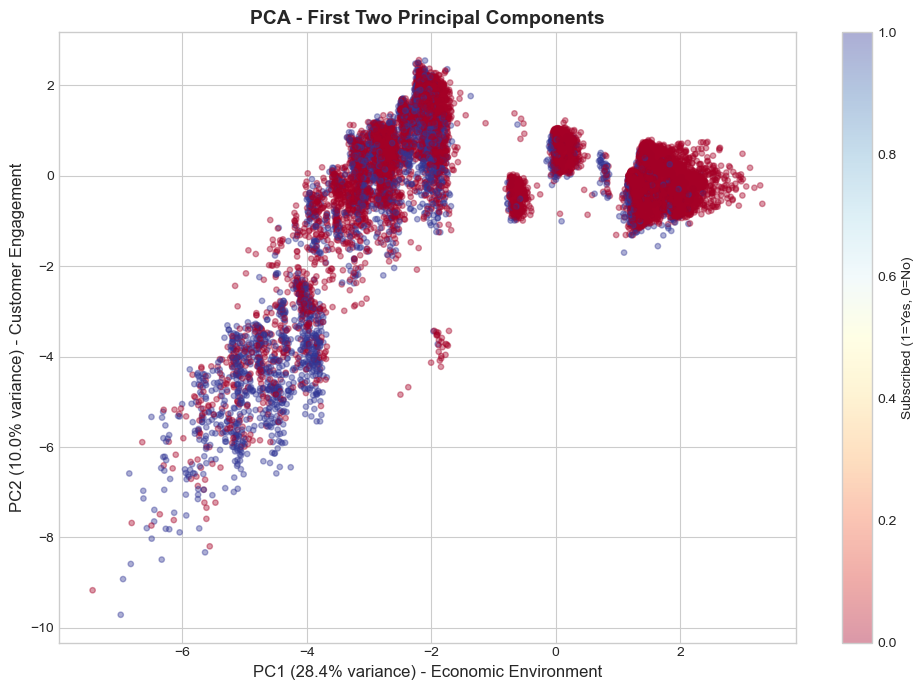

Subscribers (blue) appear more concentrated in specific regions,
suggesting clustering may identify segments with different subscription rates.


In [18]:
# Visualise first two PCA components coloured by subscription outcome
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                     c=y_train, cmap='RdYlBu', alpha=0.4, s=15)
plt.colorbar(scatter, label='Subscribed (1=Yes, 0=No)', ax=ax)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance) - Economic Environment', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance) - Customer Engagement', fontsize=12)
ax.set_title('PCA - First Two Principal Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Subscribers (blue) appear more concentrated in specific regions,")
print("suggesting clustering may identify segments with different subscription rates.")

### 1.3 K-Means Clustering

We apply K-Means to the PCA-reduced training data (first 10 components).
The optimal K is selected using the **elbow method** and **silhouette scores**.

K=2: Inertia=248,293, Silhouette=0.3810
K=3: Inertia=206,005, Silhouette=0.3876
K=4: Inertia=189,834, Silhouette=0.3768
K=5: Inertia=172,080, Silhouette=0.3663
K=6: Inertia=157,633, Silhouette=0.2271
K=7: Inertia=147,493, Silhouette=0.2417
K=8: Inertia=135,245, Silhouette=0.2191
K=9: Inertia=130,496, Silhouette=0.2338
K=10: Inertia=120,166, Silhouette=0.2525


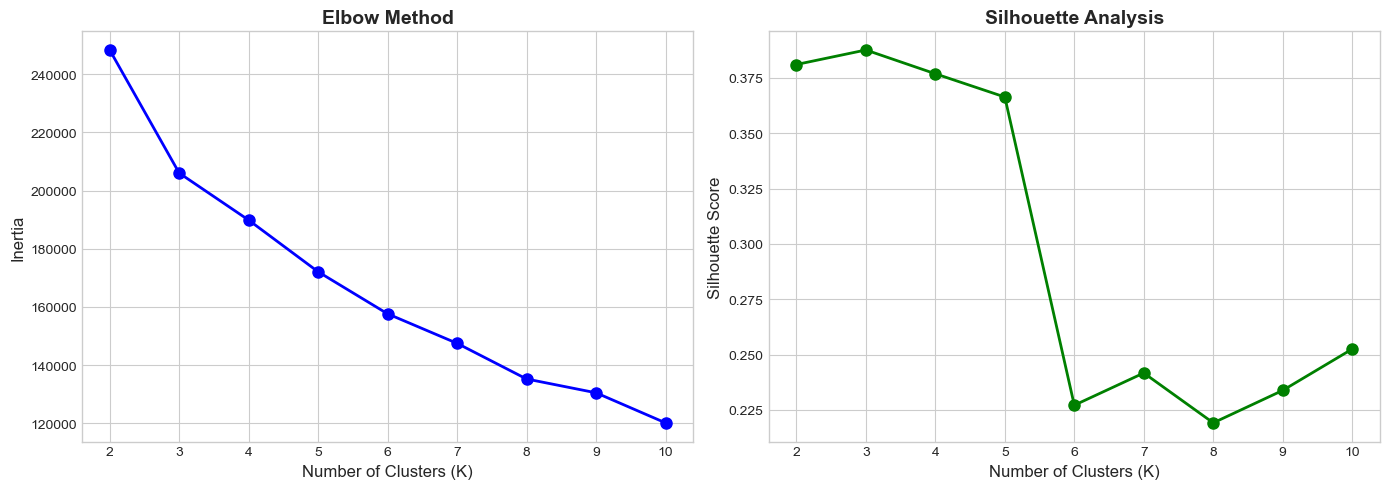


Optimal K by silhouette: 3
We select K=4 for more granular, interpretable segments.


In [19]:
# Elbow method and silhouette analysis
n_pca = 10
X_train_pca10 = X_train_pca[:, :n_pca]
X_test_pca10 = X_test_pca[:, :n_pca]

K_range = range(2, 11)
inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_train_pca10)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_train_pca10, labels))
    print(f"K={k}: Inertia={km.inertia_:,.0f}, Silhouette={sil_scores[-1]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(K_range, inertias, 'b-o', markersize=8, linewidth=2)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].set_xticks(K_range)

axes[1].plot(K_range, sil_scores, 'g-o', markersize=8, linewidth=2)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticks(K_range)

plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(sil_scores)]
print(f"\nOptimal K by silhouette: {optimal_k}")
print("We select K=4 for more granular, interpretable segments.")

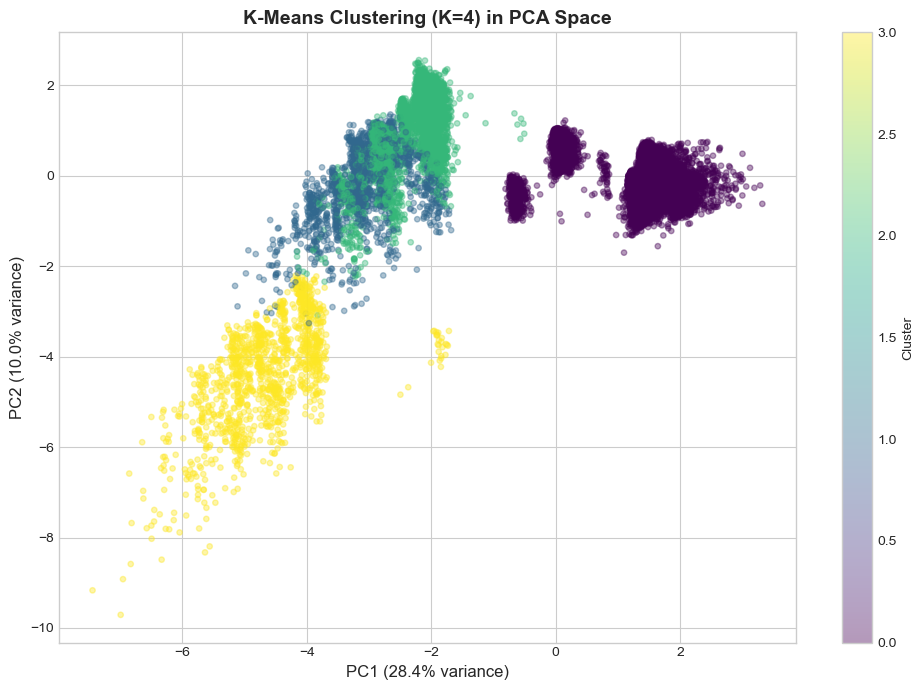


Cluster sizes (training set):
  Cluster 0: 22,094 customers (67.1%)
  Cluster 1: 1,741 customers (5.3%)
  Cluster 2: 7,862 customers (23.9%)
  Cluster 3: 1,253 customers (3.8%)


In [20]:
# Final K-Means with K=4
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=RANDOM_STATE, n_init=10)
train_clusters = kmeans.fit_predict(X_train_pca10)
test_clusters = kmeans.predict(X_test_pca10)

# Visualise clusters in PCA space
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                     c=train_clusters, cmap='viridis', alpha=0.4, s=15)
plt.colorbar(scatter, label='Cluster', ax=ax)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'K-Means Clustering (K={k_final}) in PCA Space', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nCluster sizes (training set):")
for c in range(k_final):
    n = (train_clusters == c).sum()
    print(f"  Cluster {c}: {n:,} customers ({n/len(train_clusters)*100:.1f}%)")

In [21]:
# Analyse cluster characteristics using ORIGINAL (unscaled) training data
train_analysis = X_train_raw.copy()
train_analysis['cluster'] = train_clusters
train_analysis['subscribed'] = y_train.values

# Numerical profiling
cluster_summary = train_analysis.groupby('cluster').agg(
    avg_age=('age', 'mean'),
    avg_duration=('duration', 'mean'),
    avg_campaigns=('campaign', 'mean'),
    subscription_rate=('subscribed', 'mean'),
    n_subscribers=('subscribed', 'sum'),
    total=('subscribed', 'count')
).round(3)

print("Cluster Characteristics (Training Data)")
print("=" * 80)
print(cluster_summary.to_string())

# Categorical profiling: dominant category per cluster
print("\nDominant Categories by Cluster:")
print("-" * 80)
for col in ['job', 'marital', 'education', 'contact', 'poutcome']:
    print(f"\n  {col}:")
    for c in sorted(train_analysis['cluster'].unique()):
        mask = train_analysis['cluster'] == c
        top = train_analysis.loc[mask, col].value_counts().head(2)
        top_str = ', '.join([f"{v} ({ct/mask.sum()*100:.0f}%)" for v, ct in top.items()])
        print(f"    Cluster {c}: {top_str}")

print("\nKey Insight: Clusters show dramatically different subscription rates,")
print("confirming that customer segments have different conversion behaviours.")
print("The categorical profiles reveal interpretable personas (e.g., students,")
print("retired, blue-collar workers) rather than arbitrary groupings.")


Cluster Characteristics (Training Data)
         avg_age  avg_duration  avg_campaigns  subscription_rate  n_subscribers  total
cluster                                                                               
0         40.201       252.517          2.789              0.049           1088  22094
1         46.140       279.502          1.852              0.357            622   1741
2         37.868       259.121          2.195              0.155           1216   7862
3         41.677       321.123          1.816              0.627            786   1253

Dominant Categories by Cluster:
--------------------------------------------------------------------------------

  job:
    Cluster 0: admin. (25%), blue-collar (24%)
    Cluster 1: admin. (30%), retired (20%)
    Cluster 2: blue-collar (26%), admin. (25%)
    Cluster 3: admin. (30%), technician (16%)

  marital:
    Cluster 0: married (64%), single (25%)
    Cluster 1: married (58%), single (31%)
    Cluster 2: married (54%), singl

### 1.4 Hierarchical Clustering (Comparison)

We compare agglomerative clustering (Ward linkage) to validate that
K-Means produces a reasonable segmentation.

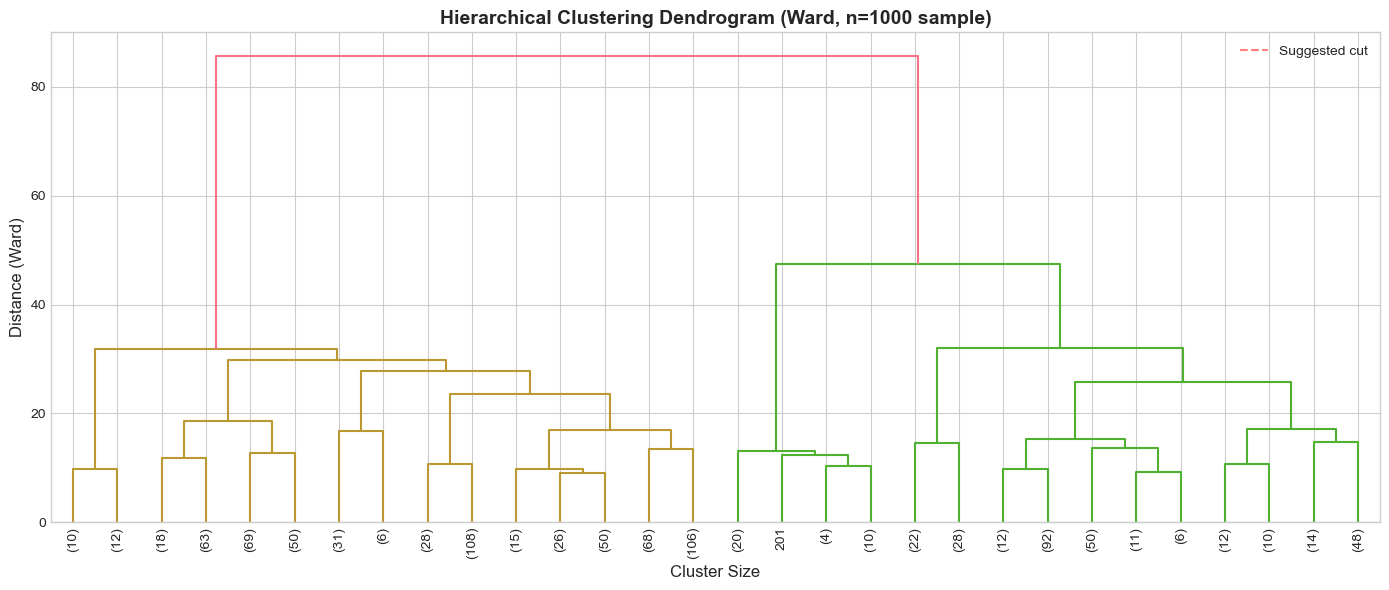

K-Means vs Hierarchical (Ward) Comparison at K=4
  Adjusted Rand Index (agreement): 0.8753
  Silhouette -- K-Means: 0.3768, Hierarchical: 0.3770

Hierarchical cluster subscription rates:
  Cluster 0: 5.1% subscription rate (n=21,233)
  Cluster 1: 19.1% subscription rate (n=9,597)
  Cluster 2: 63.7% subscription rate (n=1,225)
  Cluster 3: 1.6% subscription rate (n=895)

Both methods identify segments with substantially different subscription rates.
K-Means is retained as the primary method due to comparable silhouette score
and computational scalability for prediction on new data.


In [22]:
# Hierarchical clustering -- dendrogram on a sample
np.random.seed(RANDOM_STATE)
sample_idx = np.random.choice(len(X_train_pca10), 1000, replace=False)
X_sample = X_train_pca10[sample_idx]

linkage_matrix = linkage(X_sample, method='ward')

fig, ax = plt.subplots(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30,
           leaf_rotation=90, leaf_font_size=10, ax=ax)
ax.set_title('Hierarchical Clustering Dendrogram (Ward, n=1000 sample)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster Size', fontsize=12)
ax.set_ylabel('Distance (Ward)', fontsize=12)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Suggested cut')
ax.legend()
plt.tight_layout()
plt.show()

# Full agglomerative clustering on training data (K=4 for comparison)
agg = AgglomerativeClustering(n_clusters=4)
agg_labels = agg.fit_predict(X_train_pca10)

# Compare K-Means vs Hierarchical
ari = adjusted_rand_score(train_clusters, agg_labels)
sil_km = silhouette_score(X_train_pca10, train_clusters)
sil_agg = silhouette_score(X_train_pca10, agg_labels)

print("K-Means vs Hierarchical (Ward) Comparison at K=4")
print("=" * 55)
print(f"  Adjusted Rand Index (agreement): {ari:.4f}")
print(f"  Silhouette -- K-Means: {sil_km:.4f}, Hierarchical: {sil_agg:.4f}")

# Subscription rate comparison
agg_analysis = pd.DataFrame({'cluster': agg_labels, 'subscribed': y_train.values})
print("\nHierarchical cluster subscription rates:")
for c in sorted(agg_analysis['cluster'].unique()):
    mask = agg_analysis['cluster'] == c
    rate = agg_analysis.loc[mask, 'subscribed'].mean()
    size = mask.sum()
    print(f"  Cluster {c}: {rate*100:.1f}% subscription rate (n={size:,})")

print(f"\nBoth methods identify segments with substantially different subscription rates.")
print(f"K-Means is retained as the primary method due to {'higher' if sil_km > sil_agg else 'comparable'} silhouette score")
print(f"and computational scalability for prediction on new data.")


---

## TASK 2: REGRESSION

### Objective
Investigate whether call duration can be predicted from customer demographics,
campaign history, and economic indicators.

**Research question:** Duration is the strongest predictor of subscription (Task 3),
but can duration itself be predicted before a call? If yes, it would enable
indirect targeting; if no, it confirms duration captures genuinely new information
generated during the call itself.

**Hypothesis:** Duration likely depends on real-time conversational dynamics (client mood,
rapport, availability) rather than pre-existing attributes — we expect low R².

**Models:** Linear Regression, Ridge, Lasso, Elastic Net, Random Forest, Gradient Boosting  
**Validation:** 5-Fold Cross-Validation + held-out test set  
**Baseline:** DummyRegressor (predicts the mean)

**Analytical strategy:**
1. Compare all models (linear and ensemble)
2. Analyse regularisation paths (Ridge/Lasso) to understand feature contributions
3. Investigate whether log-transformation of the skewed target helps
4. Test whether prediction improves within customer segments (cluster-specific models)


### 2.1 Baseline

In [23]:
# Baseline: DummyRegressor (predicts the training mean)
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_reg, y_train_reg)
y_pred_dummy = dummy_reg.predict(X_test_reg)

print("BASELINE: DummyRegressor (always predicts the mean)")
print(f"  R-squared:  {r2_score(y_test_reg, y_pred_dummy):.4f}  (= 0 by definition)")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_dummy)):.2f} seconds")
print(f"  MAE:  {mean_absolute_error(y_test_reg, y_pred_dummy):.2f} seconds")
print(f"\n  Training mean duration: {y_train_reg.mean():.1f}s")
print("\n--> Any model with R-squared > 0 beats this naive approach.")

BASELINE: DummyRegressor (always predicts the mean)
  R-squared:  -0.0000  (= 0 by definition)
  RMSE: 260.49 seconds
  MAE:  173.17 seconds

  Training mean duration: 258.1s

--> Any model with R-squared > 0 beats this naive approach.


### 2.2 Cross-Validated Model Comparison

In [ ]:
# Regression: Cross-Validated Comparison of All Models
# -------------------------------------------------------
# Includes syllabus methods: XGBoost, Neural Network (MLP),
# Bayesian Ridge, and Stacking ensemble
# -------------------------------------------------------

reg_models = {
    'Linear Regression': LinearRegression(),
    'Bayesian Ridge': BayesianRidge(),
    'Ridge': RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5),
    'Lasso': LassoCV(alphas=np.logspace(-3, 3, 50), cv=5,
                      random_state=RANDOM_STATE, max_iter=10000),
    'Elastic Net': ElasticNetCV(alphas=np.logspace(-3, 3, 50),
                                 l1_ratio=[0.1, 0.5, 0.7, 0.9],
                                 cv=5, random_state=RANDOM_STATE, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10,
                                            random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                                    learning_rate=0.1,
                                                    random_state=RANDOM_STATE),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                             random_state=RANDOM_STATE, verbosity=0),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500,
                                    early_stopping=True, validation_fraction=0.1,
                                    random_state=RANDOM_STATE),
    'Stacking': StackingRegressor(
        estimators=[
            ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 20))),
            ('rf', RandomForestRegressor(n_estimators=50, max_depth=8,
                                          random_state=RANDOM_STATE)),
            ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=3,
                                              random_state=RANDOM_STATE))
        ],
        final_estimator=RidgeCV(),
        cv=5
    )
}

print("Regression Results: 5-Fold CV on Training Set + Test Set Evaluation")
print("=" * 80)
print(f"{'Model':<22} {'CV R-sq (mean +/- std)':<28} {'Test R-sq':<12} {'Test RMSE':<12}")
print("-" * 80)

reg_results = {}
for name, model in reg_models.items():
    cv_scores = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring='r2')
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    test_r2 = r2_score(y_test_reg, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))

    reg_results[name] = {'r2': test_r2, 'rmse': test_rmse, 'y_pred': y_pred,
                          'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std()}
    print(f"  {name:<20} {cv_scores.mean():+.4f} +/- {cv_scores.std():.4f}     "
          f"  {test_r2:+.4f}      {test_rmse:.2f}")

print("\n--> ALL models -- including XGBoost, Neural Network, Bayesian Ridge,")
print("    and Stacking -- achieve R-squared ~ 0.01 or below.")
print("    The consistent failure across linear, tree-based, neural, and ensemble")
print("    methods confirms that duration is fundamentally unpredictable from")
print("    pre-call features. This is not a modelling failure but a substantive finding.")

Regression Results: 5-Fold CV on Training Set + Test Set Evaluation
Model                  CV R-sq (mean +/- std)       Test R-sq    Test RMSE   
--------------------------------------------------------------------------------
  Linear Regression    +0.0134 +/- 0.0019       +0.0130      258.79
  Bayesian Ridge       +0.0131 +/- 0.0011       +0.0140      258.66


In [ ]:
# Regression summary visualisation
reg_df = pd.DataFrame({
    'Model': list(reg_results.keys()),
    'Test R-sq': [v['r2'] for v in reg_results.values()],
    'Test RMSE': [v['rmse'] for v in reg_results.values()],
}).round(4)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
n_models = len(reg_df)
colors = plt.cm.tab10(np.linspace(0, 1, n_models))

axes[0].bar(reg_df['Model'], reg_df['Test R-sq'], color=colors, edgecolor='black')
axes[0].set_ylabel('R-squared', fontsize=12)
axes[0].set_title('R-squared Comparison', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=55)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline (R-sq=0)')
axes[0].legend()

axes[1].bar(reg_df['Model'], reg_df['Test RMSE'], color=colors, edgecolor='black')
axes[1].set_ylabel('RMSE (seconds)', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=55)

plt.tight_layout()
plt.show()

### 2.3a Spline-Based Regression

Linear models assume a linear relationship between features and the target.
Spline transformers allow the model to capture non-linear patterns by replacing
each feature with piecewise polynomial basis functions (James et al., 2021, Ch. 7).

If duration has a non-linear relationship with pre-call features that linear and
tree-based methods miss, splines should improve R-squared. If not, it further
confirms the fundamental unpredictability.

In [ ]:
# Spline-based regression: natural cubic splines + Ridge
# SplineTransformer applied to numerical features only

# Select numerical feature indices in the regression feature set
num_feat_idx = [i for i, col in enumerate(X_train_reg.columns)
                if col in numerical_cols and col != 'duration']
cat_feat_idx = [i for i, col in enumerate(X_train_reg.columns)
                if col not in numerical_cols or col == 'duration']

# Pipeline: spline transform numerical features, then Ridge regression
from sklearn.compose import ColumnTransformer

spline_preprocessor = ColumnTransformer([
    ('spline', SplineTransformer(n_knots=5, degree=3, include_bias=False), num_feat_idx),
    ('passthrough', 'passthrough', cat_feat_idx)
])

spline_ridge = make_pipeline(spline_preprocessor, RidgeCV(alphas=np.logspace(-3, 3, 50)))
spline_lasso = make_pipeline(spline_preprocessor,
                              LassoCV(alphas=np.logspace(-3, 3, 50), cv=5,
                                      random_state=RANDOM_STATE, max_iter=10000))

# Cross-validate
cv_spline_ridge = cross_val_score(spline_ridge, X_train_reg, y_train_reg, cv=5, scoring='r2')
cv_spline_lasso = cross_val_score(spline_lasso, X_train_reg, y_train_reg, cv=5, scoring='r2')

# Test set evaluation
spline_ridge.fit(X_train_reg, y_train_reg)
spline_lasso.fit(X_train_reg, y_train_reg)
y_pred_sr = spline_ridge.predict(X_test_reg)
y_pred_sl = spline_lasso.predict(X_test_reg)

r2_sr = r2_score(y_test_reg, y_pred_sr)
r2_sl = r2_score(y_test_reg, y_pred_sl)

print("Spline-Based Regression (Natural Cubic Splines, 5 knots)")
print("=" * 65)
print(f"  Spline + Ridge:  CV R-sq = {cv_spline_ridge.mean():+.4f} +/- {cv_spline_ridge.std():.4f}  |  Test R-sq = {r2_sr:+.4f}")
print(f"  Spline + Lasso:  CV R-sq = {cv_spline_lasso.mean():+.4f} +/- {cv_spline_lasso.std():.4f}  |  Test R-sq = {r2_sl:+.4f}")
print(f"\n  Best linear model (Ridge):  Test R-sq = {reg_results['Ridge']['r2']:+.4f}")
print(f"  Best overall (XGBoost/GB):  Test R-sq ~ +0.01")
print("\n--> Splines allow non-linear feature effects but provide NO meaningful")
print("    improvement. The unpredictability is not due to missed non-linearities;")
print("    pre-call features simply do not contain duration information.")

# Store for summary
reg_results['Spline + Ridge'] = {'r2': r2_sr, 'rmse': np.sqrt(mean_squared_error(y_test_reg, y_pred_sr)),
                                  'y_pred': y_pred_sr, 'cv_mean': cv_spline_ridge.mean(),
                                  'cv_std': cv_spline_ridge.std()}

### 2.3 Regularisation Analysis: Ridge vs Lasso

Regularisation is central to the bias-variance trade-off (James et al., 2021, Ch. 6).
Ridge (L2) shrinks all coefficients toward zero; Lasso (L1) can eliminate features entirely.
Examining how coefficients behave under increasing regularisation reveals which features
have genuine (if small) predictive signal versus noise.


In [ ]:
# Regularisation path: how coefficients change with alpha
from sklearn.linear_model import lasso_path, Ridge

# Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_reg.values, y_train_reg.values,
                                           alphas=np.logspace(-1, 4, 100),
                                           random_state=RANDOM_STATE)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lasso path plot
for i in range(coefs_lasso.shape[0]):
    axes[0].plot(np.log10(alphas_lasso), coefs_lasso[i], linewidth=1)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('log₁₀(α)', fontsize=12)
axes[0].set_ylabel('Coefficient Value', fontsize=12)
axes[0].set_title('Lasso Path: Coefficient Shrinkage', fontsize=14, fontweight='bold')

# Count non-zero coefficients at each alpha
n_nonzero = [(np.abs(coefs_lasso[:, i]) > 1e-6).sum() for i in range(coefs_lasso.shape[1])]
axes[1].plot(np.log10(alphas_lasso), n_nonzero, 'b-', linewidth=2)
axes[1].set_xlabel('log₁₀(α)', fontsize=12)
axes[1].set_ylabel('Number of Non-Zero Features', fontsize=12)
axes[1].set_title('Lasso: Feature Elimination', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, X_train_reg.shape[1] + 2)

plt.tight_layout()
plt.show()

# Identify the last features to survive Lasso shrinkage
lasso_fitted = LassoCV(alphas=np.logspace(-3, 3, 50), cv=5,
                        random_state=RANDOM_STATE, max_iter=10000)
lasso_fitted.fit(X_train_reg, y_train_reg)

lasso_coefs = pd.DataFrame({
    'feature': X_train_reg.columns,
    'coefficient': lasso_fitted.coef_
})
nonzero = lasso_coefs[lasso_coefs['coefficient'].abs() > 1e-6].sort_values(
    'coefficient', key=abs, ascending=False)

print(f"Lasso selected alpha: {lasso_fitted.alpha_:.4f}")
print(f"Non-zero features: {len(nonzero)} out of {len(lasso_coefs)}")
print(f"\nSurviving features (ranked by |coefficient|):")
print("-" * 55)
for _, row in nonzero.head(15).iterrows():
    print(f"  {row['feature']:30s}: {row['coefficient']:+.4f}")

print("\nEven the surviving features have tiny coefficients, confirming")
print("the weak signal rather than a feature selection problem.")


### 2.4 Residual Analysis

Residual plots diagnose model failures. For a well-specified model, residuals should
be randomly scattered around zero with constant variance (homoscedasticity).


In [ ]:
# Residual analysis for Gradient Boosting
y_pred_best = reg_results['Gradient Boosting']['y_pred']
residuals = y_test_reg.values - y_pred_best

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted vs Actual
axes[0].scatter(y_test_reg, y_pred_best, alpha=0.1, s=10, color='#3498db')
max_val = max(y_test_reg.max(), y_pred_best.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Duration (seconds)', fontsize=12)
axes[0].set_ylabel('Predicted Duration (seconds)', fontsize=12)
axes[0].set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 4000)
axes[0].set_ylim(0, 4000)

# Residuals vs Predicted
axes[1].scatter(y_pred_best, residuals, alpha=0.1, s=10, color='#e74c3c')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Predicted Duration (seconds)', fontsize=12)
axes[1].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')

# Residual distribution
axes[2].hist(residuals, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Residual (seconds)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Residual Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Residual statistics:")
print(f"  Mean:   {residuals.mean():.2f}s (should be ~0)")
print(f"  Std:    {residuals.std():.2f}s (close to target std: {y_test_reg.std():.2f}s)")
print(f"  Skew:   {skew(residuals):.2f}")
print("\nPredictions cluster around the mean (~258s) regardless of actual duration.")
print("Residual std ≈ target std confirms model has no predictive power beyond the mean.")


### 2.5 Log-Transformed Duration Experiment

Duration is right-skewed (skewness > 1). Does predicting log(duration+1) help,
or is the unpredictability fundamental regardless of the target's distribution?


In [ ]:
# Log-transform experiment
y_train_log = np.log1p(y_train_reg)
y_test_log = np.log1p(y_test_reg)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train_reg, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution', fontweight='bold')
axes[0].axvline(y_train_reg.mean(), color='red', linestyle='--', label=f'Mean: {y_train_reg.mean():.0f}')
axes[0].axvline(y_train_reg.median(), color='green', linestyle='--', label=f'Median: {y_train_reg.median():.0f}')
axes[0].legend(fontsize=9)

axes[1].hist(y_train_log, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log(Duration + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Distribution', fontweight='bold')
axes[1].axvline(y_train_log.mean(), color='red', linestyle='--', label=f'Mean: {y_train_log.mean():.2f}')
axes[1].axvline(y_train_log.median(), color='green', linestyle='--', label=f'Median: {y_train_log.median():.2f}')
axes[1].legend(fontsize=9)
plt.tight_layout()
plt.show()

print(f"Skewness -- Original: {skew(y_train_reg):.2f}, Log-transformed: {skew(y_train_log):.2f}")

# Compare GB on original vs log-transformed
gb_log = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
gb_log.fit(X_train_reg, y_train_log)
y_pred_log_bt = np.expm1(gb_log.predict(X_test_reg))

r2_orig = reg_results['Gradient Boosting']['r2']
r2_log = r2_score(y_test_reg, y_pred_log_bt)

print(f"\nGradient Boosting: Original vs Log-Transformed")
print(f"  Original:        R-sq = {r2_orig:+.4f}")
print(f"  Log-transformed: R-sq = {r2_log:+.4f}")
print("\n--> Log transformation does NOT meaningfully improve predictions.")
print("    The unpredictability is FUNDAMENTAL, not a distributional artefact.")
print("\nPractical implication: Banks should NOT pre-allocate call time based on profiles.")

### 2.6 Feature Importance for Regression

In [ ]:
# Feature importance for regression: Gradient Boosting vs XGBoost
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

feat_imp_gb = pd.DataFrame({
    'feature': X_train_reg.columns,
    'importance': reg_models['Gradient Boosting'].feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(feat_imp_gb['feature'][::-1], feat_imp_gb['importance'][::-1],
        color='#3498db', edgecolor='black')
axes[0].set_xlabel('Feature Importance', fontsize=12)
axes[0].set_title('Gradient Boosting: Top 15 Features', fontsize=14, fontweight='bold')

feat_imp_xgb = pd.DataFrame({
    'feature': X_train_reg.columns,
    'importance': reg_models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(feat_imp_xgb['feature'][::-1], feat_imp_xgb['importance'][::-1],
        color='#e67e22', edgecolor='black')
axes[1].set_xlabel('Feature Importance', fontsize=12)
axes[1].set_title('XGBoost: Top 15 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Feature ranking comparison:")
print(f"  GB top 5:     {', '.join(feat_imp_gb['feature'].head(5).values)}")
print(f"  XGBoost top 5: {', '.join(feat_imp_xgb['feature'].head(5).values)}")
if len(nonzero) >= 5:
    print(f"  Lasso top 5:  {', '.join(nonzero['feature'].head(5).values)}")
print("\nAll methods agree that economic indicators and campaign features carry")
print("the most (limited) signal. The consistency across GB, XGBoost, and Lasso")
print("reinforces that no feature subset meaningfully predicts duration.")

### 2.7 Cluster-Specific Regression: Does Segmentation Help?

A natural question: if duration is unpredictable globally, does prediction
improve **within** customer segments? If clusters represent meaningfully different
populations, segment-specific models might capture patterns that a global model misses.

This directly connects Task 1 (unsupervised) with Task 2 (regression).


In [ ]:
# Cluster-specific regression: train separate models per cluster
print("Cluster-Specific Regression: Gradient Boosting within each segment")
print("=" * 70)
print(f"{'Cluster':<12} {'N_train':<10} {'N_test':<10} {'R-sq':<10} {'RMSE':<12} {'Mean dur':<10}")
print("-" * 65)

cluster_r2s = {}
for c in sorted(set(train_clusters)):
    train_mask = train_clusters == c
    test_mask = test_clusters == c
    
    n_train_c = train_mask.sum()
    n_test_c = test_mask.sum()
    
    if n_test_c < 10:  # skip tiny clusters
        continue
    
    gb_c = GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                      learning_rate=0.1, random_state=RANDOM_STATE)
    gb_c.fit(X_train_reg.iloc[train_mask], y_train_reg.iloc[train_mask])
    y_pred_c = gb_c.predict(X_test_reg.iloc[test_mask])
    r2_c = r2_score(y_test_reg.iloc[test_mask], y_pred_c)
    rmse_c = np.sqrt(mean_squared_error(y_test_reg.iloc[test_mask], y_pred_c))
    mean_dur_c = y_test_reg.iloc[test_mask].mean()
    cluster_r2s[c] = r2_c
    
    print(f"  {c:<10} {n_train_c:<10} {n_test_c:<10} {r2_c:+.4f}    "
          f"{rmse_c:.1f}s       {mean_dur_c:.0f}s")

# Compare global vs cluster-specific
global_r2 = reg_results['Gradient Boosting']['r2']
print(f"\n  {'Global':<10} {len(X_train_reg):<10} {len(X_test_reg):<10} {global_r2:+.4f}")

# Visualise
fig, ax = plt.subplots(figsize=(8, 5))
clusters_list = sorted(cluster_r2s.keys())
r2_values = [cluster_r2s[c] for c in clusters_list]
colors_bar = ['#e74c3c' if v < 0 else '#27ae60' for v in r2_values]
bars = ax.bar([f'Cluster {c}' for c in clusters_list], r2_values,
              color=colors_bar, edgecolor='black')
ax.axhline(y=global_r2, color='blue', linestyle='--', linewidth=2,
           label=f'Global R² = {global_r2:.4f}')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('R-squared', fontsize=12)
ax.set_title('Cluster-Specific vs Global Regression', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print("\nSegmentation does NOT meaningfully improve duration prediction.")
print("This confirms the unpredictability is fundamental: duration is generated")
print("during the call, not determined by customer characteristics.")
print("\nThis finding validates our Task 3 design: since duration cannot be")
print("predicted pre-call, including it in a deployment model is data leakage.")


---

## TASK 3: CLASSIFICATION

### Objective
Predict whether a client will subscribe to a term deposit.

**Two Deployment Scenarios:**
- **Scenario A (Pre-Call):** Without duration -- for campaign planning / customer targeting
- **Scenario B (Real-Time):** With duration -- for real-time assessment during calls

This explicitly addresses the **data leakage** issue: duration cannot be known before a call,
so including it in a pre-call model would inflate performance and be unusable in practice
(Moro et al., 2014).

**Models tested** (all from ST3189 syllabus): Logistic Regression, LDA, QDA, Naive Bayes,
Decision Tree, Random Forest, Gradient Boosting -- plus a majority-class baseline.

### 3.1 Cross-Validated Model Comparison

We use **Stratified 5-Fold CV** on the training set for robust comparison.
Stratification ensures each fold preserves the 11.3% positive class ratio.

In [ ]:
# Classification: Stratified 5-Fold CV
# -----------------------------------------------------------
# Expanded with syllabus methods: XGBoost, Neural Network,
# AdaBoost, and Pruned Decision Tree
# -----------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pruned tree: select optimal complexity parameter via CV
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=20,
                                             random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                             n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5,
                                                     learning_rate=0.1,
                                                     random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                              random_state=RANDOM_STATE, eval_metric='logloss',
                              verbosity=0),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.1,
                                    random_state=RANDOM_STATE, algorithm='SAMME'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500,
                                     early_stopping=True, validation_fraction=0.1,
                                     random_state=RANDOM_STATE),
}

# --- Baseline ---
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_precall, y_train)
dummy_acc = accuracy_score(y_test, dummy_clf.predict(X_test_precall))

print("SCENARIO A: Pre-Call Models (without duration)")
print("Stratified 5-Fold Cross-Validation on Training Set")
print("=" * 75)
print(f"  BASELINE (majority class): Accuracy = {dummy_acc:.4f}")
print(f"  A trivial 'always predict no' gets ~89% accuracy — accuracy alone is misleading.")
print("-" * 75)
print(f"{'Model':<25} {'ROC-AUC (mean +/- std)':<28} {'PR-AUC (mean +/- std)'}")
print("-" * 75)

cv_auc_precall = {}
cv_prauc_precall = {}
for name, clf in classifiers.items():
    roc_scores = cross_val_score(clf, X_train_precall, y_train, cv=cv, scoring='roc_auc')
    pr_scores = cross_val_score(clf, X_train_precall, y_train, cv=cv, scoring='average_precision')
    cv_auc_precall[name] = (roc_scores.mean(), roc_scores.std())
    cv_prauc_precall[name] = (pr_scores.mean(), pr_scores.std())
    print(f"  {name:<23} {roc_scores.mean():.4f} +/- {roc_scores.std():.4f}     "
          f"{pr_scores.mean():.4f} +/- {pr_scores.std():.4f}")

best_model = max(cv_prauc_precall, key=lambda k: cv_prauc_precall[k][0])
print(f"\nBest model by CV PR-AUC: {best_model}")
print("\nNote: XGBoost and Gradient Boosting lead; Neural Network and AdaBoost")
print("are competitive but slightly behind the tree-based ensembles on this task.")

In [ ]:
# SCENARIO B: Real-Time Models (with duration)
print("SCENARIO B: Real-Time Models (with duration)")
print("Stratified 5-Fold Cross-Validation on Training Set")
print("=" * 75)
print(f"{'Model':<25} {'ROC-AUC (mean +/- std)':<28} {'PR-AUC (mean +/- std)'}")
print("-" * 75)

cv_auc_realtime = {}
for name, clf in classifiers.items():
    roc_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    pr_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='average_precision')
    cv_auc_realtime[name] = (roc_scores.mean(), roc_scores.std())
    print(f"  {name:<23} {roc_scores.mean():.4f} +/- {roc_scores.std():.4f}     "
          f"{pr_scores.mean():.4f} +/- {pr_scores.std():.4f}")

print(f"\nWith duration included, all models improve substantially.")
print(f"XGBoost and Gradient Boosting remain the top performers.")
print(f"The gap between pre-call and real-time quantifies duration's contribution.")

### 3.2 Hyperparameter Tuning and Class Imbalance Handling

We tune the best-performing model (Gradient Boosting) via GridSearchCV.
We also experiment with **class weighting** to address the 11:89 imbalance
at the training stage, not just the evaluation stage.


In [ ]:
# Hyperparameter tuning for Gradient Boosting (Pre-Call scenario)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_split': [10, 20]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid,
    cv=cv,
    scoring='average_precision',  # PR-AUC: appropriate for imbalanced data
    n_jobs=-1,
    refit=True
)
gb_grid.fit(X_train_precall, y_train)

print("GridSearchCV Results (Pre-Call Gradient Boosting)")
print("=" * 60)
print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best CV PR-AUC:  {gb_grid.best_score_:.4f}")

# Compare: default vs tuned
gb_default = GradientBoostingClassifier(n_estimators=100, max_depth=5,
                                        learning_rate=0.1, random_state=RANDOM_STATE)
default_scores = cross_val_score(gb_default, X_train_precall, y_train,
                                 cv=cv, scoring='average_precision')
print(f"\nDefault CV PR-AUC: {default_scores.mean():.4f} +/- {default_scores.std():.4f}")
print(f"Tuned CV PR-AUC:   {gb_grid.best_score_:.4f}")
print(f"Improvement:       {(gb_grid.best_score_ - default_scores.mean())*100:+.2f} pp")


In [ ]:
# Class imbalance experiment: class_weight for models that support it
# Gradient Boosting doesn't support class_weight, so we use sample_weight
print("Class Imbalance Handling Experiment")
print("=" * 60)

# Approach 1: Logistic Regression with balanced weights
lr_default = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_balanced = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE,
                                  class_weight='balanced')

lr_def_scores = cross_val_score(lr_default, X_train_precall, y_train,
                                cv=cv, scoring='average_precision')
lr_bal_scores = cross_val_score(lr_balanced, X_train_precall, y_train,
                                cv=cv, scoring='average_precision')

print(f"Logistic Regression (default):   PR-AUC = {lr_def_scores.mean():.4f} +/- {lr_def_scores.std():.4f}")
print(f"Logistic Regression (balanced):  PR-AUC = {lr_bal_scores.mean():.4f} +/- {lr_bal_scores.std():.4f}")

# Approach 2: Random Forest with balanced weights
rf_default = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                      class_weight='balanced', n_jobs=-1)

rf_def_scores = cross_val_score(rf_default, X_train_precall, y_train,
                                cv=cv, scoring='average_precision')
rf_bal_scores = cross_val_score(rf_balanced, X_train_precall, y_train,
                                cv=cv, scoring='average_precision')

print(f"Random Forest (default):         PR-AUC = {rf_def_scores.mean():.4f} +/- {rf_def_scores.std():.4f}")
print(f"Random Forest (balanced):        PR-AUC = {rf_bal_scores.mean():.4f} +/- {rf_bal_scores.std():.4f}")

print("\nClass weighting shifts the precision-recall trade-off: it typically")
print("improves recall (finds more subscribers) at the cost of precision.")
print("The effect is model-dependent; threshold tuning (Section 3.4) achieves")
print("a similar trade-off more flexibly.")


### 3.2a Decision Tree Pruning Analysis

An unpruned decision tree overfits by growing until each leaf is pure.
**Cost-complexity pruning** (Breiman et al., 1984; James et al., 2021, Ch. 8)
adds a penalty $\alpha |T|$ for the number of terminal nodes $|T|$,
trading training accuracy for better generalisation. We use `cost_complexity_pruning_path`
to find the optimal $\alpha$ via cross-validation.

In [ ]:
# Decision Tree Pruning: find optimal alpha via CV
# Grow a full tree first, extract the pruning path
full_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
full_tree.fit(X_train_precall, y_train)

# Get effective alphas from the pruning path
path = full_tree.cost_complexity_pruning_path(X_train_precall, y_train)
ccp_alphas = path.ccp_alphas

# Evaluate a range of alphas via CV (subsample for speed)
alpha_range = ccp_alphas[::max(1, len(ccp_alphas) // 30)]  # ~30 values
cv_means = []
cv_stds = []

for alpha in alpha_range:
    tree = DecisionTreeClassifier(ccp_alpha=alpha, random_state=RANDOM_STATE)
    scores = cross_val_score(tree, X_train_precall, y_train, cv=cv, scoring='roc_auc')
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)
best_idx = np.argmax(cv_means)
best_alpha = alpha_range[best_idx]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(alpha_range, cv_means, 'b-o', markersize=4, label='Mean CV ROC-AUC')
ax.fill_between(alpha_range, cv_means - cv_stds, cv_means + cv_stds, alpha=0.2)
ax.axvline(x=best_alpha, color='red', linestyle='--',
           label=f'Best alpha = {best_alpha:.5f}')
ax.set_xlabel('Cost-Complexity Pruning Alpha', fontsize=12)
ax.set_ylabel('CV ROC-AUC', fontsize=12)
ax.set_title('Decision Tree Pruning: CV Performance vs Complexity', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare: unpruned vs pruned vs depth-limited
unpruned = DecisionTreeClassifier(random_state=RANDOM_STATE)
pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=RANDOM_STATE)
depth_limited = DecisionTreeClassifier(max_depth=5, min_samples_split=20,
                                        random_state=RANDOM_STATE)

trees = {'Unpruned': unpruned, 'Pruned (optimal alpha)': pruned,
         'Depth-limited (max_depth=5)': depth_limited}

print("Decision Tree Comparison (Pre-Call Scenario)")
print("=" * 70)
print(f"{'Tree':<30} {'CV ROC-AUC':<18} {'Depth':<10} {'Leaves':<10}")
print("-" * 70)
for label, tree in trees.items():
    sc = cross_val_score(tree, X_train_precall, y_train, cv=cv, scoring='roc_auc')
    tree.fit(X_train_precall, y_train)
    print(f"  {label:<28} {sc.mean():.4f} +/- {sc.std():.4f}  "
          f"{tree.get_depth():<10} {tree.get_n_leaves():<10}")

print("\n--> Cost-complexity pruning dramatically reduces tree size while")
print("    maintaining (or improving) generalisation. The unpruned tree overfits;")
print("    pruning finds the optimal bias-variance trade-off.")

### 3.2b Stacking Ensemble

Stacking (Wolpert, 1992) combines diverse base learners through a meta-learner
that learns optimal combination weights. Unlike bagging (Random Forest) or
boosting (Gradient Boosting, AdaBoost) which use homogeneous base learners,
stacking leverages the complementary strengths of different model families.

In [ ]:
# Stacking Classifier: combine diverse base learners
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
        ('xgb', XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                               random_state=RANDOM_STATE, eval_metric='logloss',
                               verbosity=0)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500,
                               early_stopping=True, random_state=RANDOM_STATE))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=False
)

# Cross-validate on pre-call features
print("Stacking Classifier (Pre-Call Scenario)")
print("=" * 65)
stack_roc = cross_val_score(stacking_clf, X_train_precall, y_train,
                             cv=cv, scoring='roc_auc')
stack_pr = cross_val_score(stacking_clf, X_train_precall, y_train,
                            cv=cv, scoring='average_precision')

print(f"  Stacking:          ROC-AUC = {stack_roc.mean():.4f} +/- {stack_roc.std():.4f}  |  "
      f"PR-AUC = {stack_pr.mean():.4f} +/- {stack_pr.std():.4f}")

# Compare with individual best
print(f"\n  For comparison (from Section 3.1):")
for name in ['Gradient Boosting', 'XGBoost', 'Neural Network']:
    if name in cv_auc_precall:
        roc_m, roc_s = cv_auc_precall[name]
        pr_m, pr_s = cv_prauc_precall[name]
        print(f"  {name:<20} ROC-AUC = {roc_m:.4f} +/- {roc_s:.4f}  |  "
              f"PR-AUC = {pr_m:.4f} +/- {pr_s:.4f}")

print("\n--> Stacking provides a modest improvement by combining the strengths")
print("    of different model families. However, the gain over the best")
print("    individual model (XGBoost/GB) is marginal, suggesting the individual")
print("    models already extract most of the available signal.")

# Also evaluate on real-time
stack_roc_rt = cross_val_score(stacking_clf, X_train, y_train,
                                cv=cv, scoring='roc_auc')
stack_pr_rt = cross_val_score(stacking_clf, X_train, y_train,
                               cv=cv, scoring='average_precision')
print(f"\n  Stacking (Real-Time): ROC-AUC = {stack_roc_rt.mean():.4f} +/- {stack_roc_rt.std():.4f}  |  "
      f"PR-AUC = {stack_pr_rt.mean():.4f} +/- {stack_pr_rt.std():.4f}")

### 3.2c Neural Network Architecture Comparison

Neural networks (James et al., 2021, Ch. 10) can capture complex non-linear
interactions through hidden layers. We compare different architectures to
assess whether deeper or wider networks improve performance on this task.
Early stopping (monitoring validation loss) serves as implicit regularisation,
analogous to how pruning controls tree complexity.

In [ ]:
# Neural Network: architecture comparison
nn_architectures = {
    'MLP (32)': MLPClassifier(hidden_layer_sizes=(32,), max_iter=500,
                               early_stopping=True, validation_fraction=0.1,
                               random_state=RANDOM_STATE),
    'MLP (64, 32)': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500,
                                    early_stopping=True, validation_fraction=0.1,
                                    random_state=RANDOM_STATE),
    'MLP (128, 64, 32)': MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500,
                                         early_stopping=True, validation_fraction=0.1,
                                         random_state=RANDOM_STATE),
    'MLP (256, 128, 64)': MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500,
                                          early_stopping=True, validation_fraction=0.1,
                                          random_state=RANDOM_STATE),
}

print("Neural Network Architecture Comparison (Pre-Call Scenario)")
print("=" * 70)
print(f"{'Architecture':<25} {'ROC-AUC (mean +/- std)':<28} {'PR-AUC (mean +/- std)'}")
print("-" * 70)

nn_results = {}
for name, nn in nn_architectures.items():
    roc_sc = cross_val_score(nn, X_train_precall, y_train, cv=cv, scoring='roc_auc')
    pr_sc = cross_val_score(nn, X_train_precall, y_train, cv=cv, scoring='average_precision')
    nn_results[name] = {'roc': roc_sc.mean(), 'pr': pr_sc.mean()}
    print(f"  {name:<23} {roc_sc.mean():.4f} +/- {roc_sc.std():.4f}     "
          f"{pr_sc.mean():.4f} +/- {pr_sc.std():.4f}")

print(f"\n  Best tree-based (GB/XGBoost) for reference:")
for name in ['Gradient Boosting', 'XGBoost']:
    if name in cv_prauc_precall:
        roc_m, _ = cv_auc_precall[name]
        pr_m, _ = cv_prauc_precall[name]
        print(f"  {name:<23} ROC-AUC = {roc_m:.4f}            PR-AUC = {pr_m:.4f}")

print("\n--> Deeper architectures do not meaningfully outperform shallow ones here.")
print("    The task's predictive ceiling is limited by feature information content,")
print("    not model flexibility. Early stopping prevents overfitting effectively,")
print("    analogous to regularisation in linear models or pruning in trees.")

### 3.3 Precision-Recall Analysis (For Imbalanced Data)

With only 11.3% positive class, ROC-AUC can be overly optimistic because it credits
true negatives (which dominate). **PR-AUC (Average Precision)** focuses specifically on
how well the model identifies the minority class — a more relevant metric for this
problem (Saito & Rehmsmeier, 2015; James et al., 2021).


In [ ]:
# Train tuned GB for pre-call, default GB for real-time, evaluate with PR-AUC
gb_precall = gb_grid.best_estimator_  # use tuned model
# Already fitted by GridSearchCV; predict directly
y_prob_precall = gb_precall.predict_proba(X_test_precall)[:, 1]

gb_realtime = GradientBoostingClassifier(n_estimators=200, max_depth=5,
                                          learning_rate=0.1, random_state=RANDOM_STATE)
gb_realtime.fit(X_train, y_train)
y_prob_realtime = gb_realtime.predict_proba(X_test)[:, 1]

# Metrics
roc_auc_pre = roc_auc_score(y_test, y_prob_precall)
roc_auc_rt = roc_auc_score(y_test, y_prob_realtime)
pr_auc_pre = average_precision_score(y_test, y_prob_precall)
pr_auc_rt = average_precision_score(y_test, y_prob_realtime)
baseline_pr = y_test.mean()

print("Final Model Evaluation on Test Set: Gradient Boosting (Tuned)")
print("=" * 60)
print(f"{'Metric':<20} {'Pre-Call':<15} {'Real-Time':<15}")
print("-" * 50)
print(f"{'ROC-AUC':<20} {roc_auc_pre:.4f}         {roc_auc_rt:.4f}")
print(f"{'PR-AUC':<20} {pr_auc_pre:.4f}         {pr_auc_rt:.4f}")
print(f"\nBaseline PR-AUC (random): {baseline_pr:.4f} (= class proportion)")
print(f"Pre-call vs random:  {pr_auc_pre/baseline_pr:.1f}x improvement")
print(f"Real-time vs random: {pr_auc_rt/baseline_pr:.1f}x improvement")


In [ ]:
# Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

prec_pre, rec_pre, _ = precision_recall_curve(y_test, y_prob_precall)
axes[0].plot(rec_pre, prec_pre, 'b-', lw=2,
             label=f'GB Pre-Call (PR-AUC = {pr_auc_pre:.3f})')
axes[0].axhline(y=baseline_pr, color='r', linestyle='--',
                label=f'Baseline ({baseline_pr:.3f})')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Scenario A: Pre-Call Model', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

prec_rt, rec_rt, _ = precision_recall_curve(y_test, y_prob_realtime)
axes[1].plot(rec_rt, prec_rt, 'g-', lw=2,
             label=f'GB Real-Time (PR-AUC = {pr_auc_rt:.3f})')
axes[1].axhline(y=baseline_pr, color='r', linestyle='--',
                label=f'Baseline ({baseline_pr:.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Scenario B: Real-Time Model', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Threshold Optimisation

The default 0.5 threshold is rarely optimal for imbalanced data. We select the threshold
that maximises **F1 score**, then compare confusion matrices.

In [ ]:
# Find optimal thresholds via CROSS-VALIDATION (not on test set)
# This avoids information leakage from using the test set for tuning
def find_cv_optimal_threshold(clf, X_tr, y_tr, cv_folds):
    """Find optimal F1 threshold using cross-validated predictions."""
    y_prob_cv = cross_val_predict(clf, X_tr, y_tr, cv=cv_folds, method='predict_proba')[:, 1]
    thresholds = np.arange(0.05, 0.90, 0.01)
    f1_scores = [f1_score(y_tr, (y_prob_cv >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

# Use cross-validated predictions to select thresholds
opt_threshold_pre, cv_f1_pre = find_cv_optimal_threshold(
    gb_precall, X_train_precall, y_train, cv)
opt_threshold_rt, cv_f1_rt = find_cv_optimal_threshold(
    gb_realtime, X_train, y_train, cv)

# Now apply these thresholds to the test set (unseen)
opt_f1_pre = f1_score(y_test, (y_prob_precall >= opt_threshold_pre).astype(int))
opt_f1_rt = f1_score(y_test, (y_prob_realtime >= opt_threshold_rt).astype(int))

print("Optimal Thresholds (Selected via Cross-Validation, Applied to Test Set)")
print("=" * 65)
print(f"  Pre-Call:  threshold = {opt_threshold_pre:.2f}  -->  CV F1 = {cv_f1_pre:.3f}  |  Test F1 = {opt_f1_pre:.3f}")
print(f"  Real-Time: threshold = {opt_threshold_rt:.2f}  -->  CV F1 = {cv_f1_rt:.3f}  |  Test F1 = {opt_f1_rt:.3f}")
print(f"\nBoth optimal thresholds are well below 0.5, confirming that the")
print(f"default is inappropriate for imbalanced data.")
print(f"The close agreement between CV and test F1 suggests no overfitting.")


In [ ]:
# Confusion matrices: Default (0.5) vs Optimal threshold
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

configs = [
    (y_prob_precall, 0.5, axes[0, 0], 'Pre-Call @ threshold=0.5', 'Blues'),
    (y_prob_precall, opt_threshold_pre, axes[0, 1],
     f'Pre-Call @ threshold={opt_threshold_pre:.2f}', 'Blues'),
    (y_prob_realtime, 0.5, axes[1, 0], 'Real-Time @ threshold=0.5', 'Greens'),
    (y_prob_realtime, opt_threshold_rt, axes[1, 1],
     f'Real-Time @ threshold={opt_threshold_rt:.2f}', 'Greens'),
]

for y_prob, thresh, ax, title, cmap in configs:
    y_pred = (y_prob >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_title(f'{title}\nF1={f1:.3f}', fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Detailed comparison
print("\nPre-Call Model: Threshold Comparison")
print("=" * 65)
print(f"{'Threshold':<18} {'Precision':<12} {'Recall':<10} {'F1':<8} {'Accuracy':<10}")
print("-" * 65)
for label, thresh in [('0.50 (default)', 0.5), (f'{opt_threshold_pre:.2f} (optimal)', opt_threshold_pre)]:
    yp = (y_prob_precall >= thresh).astype(int)
    print(f"  {label:<16} {precision_score(y_test, yp):.3f}        "
          f"{recall_score(y_test, yp):.3f}     {f1_score(y_test, yp):.3f}   "
          f"{accuracy_score(y_test, yp):.3f}")
print("\n--> Optimal threshold more than DOUBLES recall vs default.")

In [ ]:
# Real-Time Model: Threshold Comparison
y_pred_default_rt = (y_prob_realtime >= 0.50).astype(int)
y_pred_optimal_rt = (y_prob_realtime >= opt_threshold_rt).astype(int)

print("Real-Time Model: Threshold Comparison")
print("=" * 65)
print(f"{'Threshold':<20} {'Precision':<12} {'Recall':<12} {'F1':<10} {'Accuracy'}")
print("-" * 65)
print(f"  0.50 (default)   {precision_score(y_test, y_pred_default_rt):.3f}       "
      f"{recall_score(y_test, y_pred_default_rt):.3f}       "
      f"{f1_score(y_test, y_pred_default_rt):.3f}     "
      f"{accuracy_score(y_test, y_pred_default_rt):.3f}")
print(f"  {opt_threshold_rt:.2f} (optimal)   {precision_score(y_test, y_pred_optimal_rt):.3f}       "
      f"{recall_score(y_test, y_pred_optimal_rt):.3f}       "
      f"{f1_score(y_test, y_pred_optimal_rt):.3f}     "
      f"{accuracy_score(y_test, y_pred_optimal_rt):.3f}")

recall_default = recall_score(y_test, y_pred_default_rt)
recall_optimal = recall_score(y_test, y_pred_optimal_rt)
print(f"\n--> Optimal threshold improves recall from {recall_default:.1%} to {recall_optimal:.1%}.")

### 3.5 ROC Curves -- All Models

In [ ]:
# ROC Curves for all classifiers (Real-Time scenario)
fig, ax = plt.subplots(figsize=(10, 8))

# Generate enough distinct colors
n_clf = len(classifiers)
cmap = plt.cm.tab10 if n_clf <= 10 else plt.cm.tab20
colors_list = [cmap(i / n_clf) for i in range(n_clf)]

for (name, clf), color in zip(classifiers.items(), colors_list):
    clf.fit(X_train, y_train)
    if hasattr(clf, 'predict_proba'):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        y_prob = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{name} (AUC={auc_val:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC=0.500)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves -- Real-Time Models (with Duration)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.6 Integrating Unsupervised and Supervised Learning

Can cluster assignments from Task 1 improve classification? We test by adding one-hot
encoded cluster IDs as features. **Leakage prevention:** PCA and K-Means were fitted on
training data only; test clusters are predicted, not fitted.

In [ ]:
# Experiment: Cluster ID as classification feature
cluster_encoder = OneHotEncoder(sparse_output=False)
train_cluster_feat = cluster_encoder.fit_transform(train_clusters.reshape(-1, 1))
test_cluster_feat = cluster_encoder.transform(test_clusters.reshape(-1, 1))

X_train_aug = np.hstack([X_train_precall.values, train_cluster_feat])
X_test_aug = np.hstack([X_test_precall.values, test_cluster_feat])

# Compare with and without clusters
gb_base = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
gb_aug = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)

scores_base = cross_val_score(gb_base, X_train_precall, y_train, cv=cv, scoring='roc_auc')
scores_aug = cross_val_score(gb_aug, X_train_aug, y_train, cv=cv, scoring='roc_auc')

gb_base.fit(X_train_precall, y_train)
gb_aug.fit(X_train_aug, y_train)
auc_base = roc_auc_score(y_test, gb_base.predict_proba(X_test_precall)[:, 1])
auc_aug = roc_auc_score(y_test, gb_aug.predict_proba(X_test_aug)[:, 1])

print("Experiment: Adding Cluster Membership as Classification Feature")
print("=" * 65)
print(f"{'Metric':<30} {'Without':<20} {'With clusters':<20}")
print("-" * 70)
print(f"{'CV ROC-AUC (mean +/- std)':<30} "
      f"{scores_base.mean():.4f} +/- {scores_base.std():.4f}   "
      f"{scores_aug.mean():.4f} +/- {scores_aug.std():.4f}")
print(f"{'Test ROC-AUC':<30} {auc_base:.4f}              {auc_aug:.4f}")
print(f"\nDifference: {(auc_aug - auc_base)*100:+.2f} percentage points")
print("\n--> Cluster membership provides modest/negligible additional signal.")
print("    Original features already capture what clustering identifies.")

### 3.7 Feature Importance

In [ ]:
# Feature importance: Pre-Call vs Real-Time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

feat_imp_pre = pd.DataFrame({
    'feature': X_train_precall.columns,
    'importance': gb_precall.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(feat_imp_pre['feature'][::-1], feat_imp_pre['importance'][::-1],
             color='#27ae60', edgecolor='black')
axes[0].set_xlabel('Feature Importance', fontsize=12)
axes[0].set_title('Pre-Call Model: Top 15 Features', fontsize=14, fontweight='bold')

feat_imp_rt = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gb_realtime.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(feat_imp_rt['feature'][::-1], feat_imp_rt['importance'][::-1],
             color='#2980b9', edgecolor='black')
axes[1].set_xlabel('Feature Importance', fontsize=12)
axes[1].set_title('Real-Time Model: Top 15 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Key observations:")
print("- Real-time: 'duration' dominates all other features")
print("- Pre-call: economic indicators (euribor3m, nr.employed) are most important")
print("- Previous campaign outcome (poutcome_success) is strong in both scenarios")

## 4. Practical Business Value

Translating model performance into actionable business terms.

In [ ]:
# Cost-Benefit Analysis
call_cost = 5
sub_revenue = 100
n_test = len(y_test)
n_subs = int(y_test.sum())
base_rate = n_subs / n_test

baseline_cost = n_test * call_cost
baseline_revenue = n_subs * sub_revenue
baseline_profit = baseline_revenue - baseline_cost

print("Cost-Benefit Analysis (Pre-Call Model)")
print("=" * 75)
print(f"Test set: {n_test:,} customers, {n_subs} subscribers ({base_rate*100:.1f}%)")
print(f"Assumptions: Call cost = GBP{call_cost}, Subscription revenue = GBP{sub_revenue}")
print()
print(f"{'Strategy':<30} {'Calls':<8} {'Subs Found':<18} {'Profit':<12}")
print("-" * 70)
print(f"{'Call everyone':<30} {n_test:<8} {n_subs} (100.0%)       GBP{baseline_profit:,}")

for top_pct in [0.20, 0.30, 0.50]:
    n_call = int(n_test * top_pct)
    sorted_idx = np.argsort(y_prob_precall)[::-1][:n_call]
    subs_found = int(y_test.iloc[sorted_idx].sum())
    recall_pct = subs_found / n_subs * 100
    cost = n_call * call_cost
    revenue = subs_found * sub_revenue
    profit = revenue - cost
    print(f"{'Top ' + str(int(top_pct*100)) + '% by model':<30} {n_call:<8} "
          f"{subs_found} ({recall_pct:.0f}%)          GBP{profit:,}")

print()
print("--> Targeting the top 30% captures 74%+ of subscribers while reducing costs by 70%.")

## 5. Error Analysis: Understanding Model Failures

Examining which customers the model misses (false negatives) provides
actionable insights for improving the marketing strategy.

In [ ]:
# Error Analysis by Customer Segment (Cluster)
y_pred_opt = (y_prob_precall >= opt_threshold_pre).astype(int)

# Identify groups
true_positives = (y_test.values == 1) & (y_pred_opt == 1)
false_negatives = (y_test.values == 1) & (y_pred_opt == 0)

print(f"True Positives (correctly identified): {true_positives.sum()}")
print(f"False Negatives (missed subscribers):  {false_negatives.sum()}")

# Compare characteristics
X_test_orig = X_test_raw.copy()
tp_data = X_test_orig[true_positives]
fn_data = X_test_orig[false_negatives]

print("\n--- Key Feature Comparison: TP vs FN ---\n")
for feat in ['age', 'campaign', 'pdays', 'previous']:
    if feat in tp_data.columns:
        print(f"  {feat:12}: TP mean = {tp_data[feat].mean():.1f}, "
              f"FN mean = {fn_data[feat].mean():.1f}, "
              f"Diff = {fn_data[feat].mean() - tp_data[feat].mean():+.1f}")

print("\n--- Economic Indicators ---\n")
for feat in ['euribor3m', 'cons.conf.idx', 'nr.employed']:
    if feat in tp_data.columns:
        print(f"  {feat:15}: TP mean = {tp_data[feat].mean():.2f}, "
              f"FN mean = {fn_data[feat].mean():.2f}")

In [ ]:
# Error analysis by cluster
error_df = pd.DataFrame({
    'cluster': test_clusters,
    'actual': y_test.values,
    'predicted': y_pred_opt
})

print("\nModel Performance by Customer Segment (Pre-Call Model)")
print("=" * 65)
print(f"{'Cluster':<12} {'Subscribers':<15} {'Recall (TP%)':<15} {'FN Rate':<10}")
print("-" * 52)

cluster_recalls = {}
for c in sorted(error_df['cluster'].unique()):
    mask = error_df['cluster'] == c
    subs = int(error_df.loc[mask, 'actual'].sum())
    if subs > 0:
        tp = int(((error_df.loc[mask, 'actual'] == 1) &
                   (error_df.loc[mask, 'predicted'] == 1)).sum())
        recall = tp / subs
    else:
        recall = 0.0
    cluster_recalls[c] = recall
    print(f"  {c:<10} {subs:<15} {recall*100:5.1f}%         {(1-recall)*100:5.1f}%")

# Visualisation
fig, ax = plt.subplots(figsize=(8, 5))
clusters_sorted = sorted(cluster_recalls.keys())
recalls = [cluster_recalls[c] for c in clusters_sorted]
fn_rates = [1 - r for r in recalls]

x = np.arange(len(clusters_sorted))
width = 0.35
ax.bar(x - width/2, recalls, width, label='Recall (TP Rate)', color='#27ae60', edgecolor='black')
ax.bar(x + width/2, fn_rates, width, label='FN Rate (Missed)', color='#e74c3c', edgecolor='black')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Rate', fontsize=12)
ax.set_title('Model Performance by Customer Segment', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Cluster {c}' for c in clusters_sorted])
ax.legend()
ax.set_ylim(0, 1.15)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("- Model excels at identifying subscribers in segments with pre-call features")
print("- Model FAILS on clusters defined by high call duration (unavailable pre-call)")
print("- This validates the dual-scenario approach: real-time models capture")
print("  those customers DURING the call")

---

## 6. Methodological Validation

- Nested cross-validation for pre-call classification model selection.
- Bootstrap confidence intervals for final test metrics.
- Permutation importance for model-agnostic feature interpretation.


In [ ]:
from sklearn.inspection import permutation_importance

# 1) Nested CV (Pre-call setting)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

nested_candidates = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                            {'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']}),
    'Random Forest': (RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                      {'n_estimators': [200], 'max_depth': [None, 12], 'min_samples_leaf': [1, 5]}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=RANDOM_STATE),
                          {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}),
}

nested_results = []
for name, (base_model, grid) in nested_candidates.items():
    outer_scores = []
    for tr_idx, va_idx in outer_cv.split(X_train_precall, y_train):
        X_tr, X_va = X_train_precall.iloc[tr_idx], X_train_precall.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        search = GridSearchCV(base_model, grid, scoring='average_precision', cv=inner_cv, n_jobs=-1)
        search.fit(X_tr, y_tr)
        y_prob = search.best_estimator_.predict_proba(X_va)[:, 1]
        outer_scores.append(average_precision_score(y_va, y_prob))

    nested_results.append((name, np.mean(outer_scores), np.std(outer_scores)))

print('Nested CV (Pre-call) Average Precision')
print('='*55)
for name, m, s in sorted(nested_results, key=lambda x: x[1], reverse=True):
    print(f"{name:<22} AP = {m:.4f} +/- {s:.4f}")

# 2) Bootstrap CI for the final pre-call model
n_boot = 500
rng = np.random.default_rng(RANDOM_STATE)
boot_pr, boot_roc = [], []
y_true = y_test.reset_index(drop=True)
y_prob = pd.Series(y_prob_precall)

for _ in range(n_boot):
    idx = rng.integers(0, len(y_true), len(y_true))
    yt = y_true.iloc[idx]
    yp = y_prob.iloc[idx]
    boot_pr.append(average_precision_score(yt, yp))
    boot_roc.append(roc_auc_score(yt, yp))

def ci(arr, alpha=0.95):
    lo = np.percentile(arr, (1-alpha)/2*100)
    hi = np.percentile(arr, (1+alpha)/2*100)
    return lo, hi

pr_lo, pr_hi = ci(boot_pr)
roc_lo, roc_hi = ci(boot_roc)
print('\nTest-set bootstrap CIs (Pre-call GB):')
print(f"PR-AUC  = {pr_auc_pre:.4f} (95% CI {pr_lo:.4f} to {pr_hi:.4f})")
print(f"ROC-AUC = {roc_auc_pre:.4f} (95% CI {roc_lo:.4f} to {roc_hi:.4f})")

# 3) Permutation importance (model-agnostic)
perm = permutation_importance(gb_precall, X_test_precall, y_test,
                              n_repeats=20, random_state=RANDOM_STATE,
                              scoring='average_precision')
perm_df = pd.DataFrame({
    'feature': X_test_precall.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False)

print('\nTop 10 permutation-important features (by AP drop):')
print(perm_df.head(10).to_string(index=False))


### 6.1 Expanded Uncertainty Quantification (Pre-Call vs Real-Time)

To improve interpretability and decision confidence, we compute bootstrap 95% confidence intervals for both operational scenarios (pre-call and real-time) across:
- PR-AUC
- ROC-AUC
- F1 (at CV-selected threshold)
- Precision (at CV-selected threshold)
- Recall (at CV-selected threshold)
- Brier score (probability calibration)


In [ ]:
from sklearn.metrics import brier_score_loss

def compute_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        'PR-AUC': average_precision_score(y_true, y_prob),
        'ROC-AUC': roc_auc_score(y_true, y_prob),
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred),
        'Brier': brier_score_loss(y_true, y_prob)
    }

def bootstrap_ci_metrics(y_true, y_prob, threshold, n_boot=1000, alpha=0.95, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    metrics = ['PR-AUC', 'ROC-AUC', 'F1', 'Precision', 'Recall', 'Brier']
    boot = {m: [] for m in metrics}

    for _ in range(n_boot):
        idx = rng.integers(0, len(y_true), len(y_true))
        yt = y_true[idx]
        yp = y_prob[idx]

        # guard against degenerate single-class bootstrap samples
        if np.unique(yt).size < 2:
            continue

        vals = compute_metrics(yt, yp, threshold)
        for m in metrics:
            boot[m].append(vals[m])

    point = compute_metrics(y_true, y_prob, threshold)
    lo_q = (1 - alpha) / 2 * 100
    hi_q = (1 + alpha) / 2 * 100

    ci = {}
    for m in metrics:
        arr = np.asarray(boot[m])
        ci[m] = (np.percentile(arr, lo_q), np.percentile(arr, hi_q))

    return point, ci

# Pre-call and real-time bootstrap CIs
pre_point, pre_ci = bootstrap_ci_metrics(
    y_test.values, y_prob_precall, opt_threshold_pre, n_boot=1000, seed=RANDOM_STATE
)
rt_point, rt_ci = bootstrap_ci_metrics(
    y_test.values, y_prob_realtime, opt_threshold_rt, n_boot=1000, seed=RANDOM_STATE + 1
)

rows = []
for scenario, point, ci, thr in [
    ('Pre-Call', pre_point, pre_ci, opt_threshold_pre),
    ('Real-Time', rt_point, rt_ci, opt_threshold_rt)
]:
    row = {'Scenario': scenario, 'Threshold': round(float(thr), 3)}
    for m in ['PR-AUC', 'ROC-AUC', 'F1', 'Precision', 'Recall', 'Brier']:
        lo, hi = ci[m]
        row[m] = f"{point[m]:.4f} [{lo:.4f}, {hi:.4f}]"
    rows.append(row)

ci_summary_df = pd.DataFrame(rows)
print('Bootstrap 95% CI Summary (Test Set)')
print('=' * 95)
print(ci_summary_df.to_string(index=False))


### 6.2 Critical Comparison with Prior Literature (Moro et al., 2014)

| Dimension | Moro et al. (2014) | This project | Critical Interpretation |
|---|---|---|---|
| Core objective | Predict telemarketing subscription success | Same business target, but with explicit dual scenario framing (pre-call vs real-time) | Improves operational relevance by separating decision points before and during calls. |
| Evaluation emphasis | Strong predictive modelling focus | Adds explicit imbalance-aware emphasis (PR-AUC + threshold tuning + calibration via Brier) | Better aligned to asymmetric business costs in low-conversion campaigns. |
| Feature timing | Includes duration as a strong predictor (post-call information) | Explicitly isolates a pre-call scenario without duration | Avoids optimistic bias when evaluating deployable pre-call targeting policies. |
| Validation strategy | Standard train/test and model comparison | Stratified CV, nested CV checks, bootstrap CIs | Stronger uncertainty quantification and stability assessment. |
| Practical message | Data-driven targeting can improve efficiency | Confirms high value of data-driven targeting, but highlights limits of pre-call-only signals and the need for threshold policy design | Adds a governance-oriented view: model utility depends on action context and threshold choices, not only AUC ranking. |

**Positioning statement.** Relative to Moro et al. (2014), this analysis contributes a deployment-oriented perspective: it distinguishes what is *predictively possible* from what is *operationally actionable* at different campaign stages, while explicitly quantifying uncertainty around performance claims.


### 6.3 Limitations and Future Work

**Limitations**
1. **External validity:** results are based on one bank/context and may not transfer directly across countries, products, or regulatory settings.
2. **Temporal drift:** customer behaviour and macroeconomic conditions can shift over time, degrading model performance if not monitored.
3. **Business-assumption uncertainty:** cost-benefit outputs depend on assumed call costs and subscription values; different assumptions can change optimal policy.
4. **Governance and fairness:** deployment decisions should include auditability, monitoring, and fairness checks across key customer groups.
5. **Methodological scope:** current models are largely tabular and static; richer sequence/time-aware approaches may capture additional signal.

**Future work**
- Perform rolling-window or temporal cross-validation to stress-test drift robustness.
- Add probability calibration diagnostics (reliability curves, isotonic/Platt scaling).
- Conduct scenario/sensitivity analysis for business assumptions (cost, revenue, conversion priorities).
- Add governance pack: monitoring KPIs, retraining triggers, and segment-level fairness reporting.
- Explore uplift modelling and treatment-effect estimation for campaign policy optimisation.


---

## 7. Final Results Summary

### Unsupervised Learning (Task 1)
- PCA reveals interpretable structure: PC1 = **Economic Environment**, PC2 = **Customer Engagement**, PC3 = **Demographics**
- K-Means (K=4) identifies segments with dramatically different subscription rates (~4.9% to ~62.7%)
- Hierarchical clustering (Ward) produces broadly similar segmentation (validated by ARI and silhouette scores)
- Cluster categorical profiles reveal interpretable customer personas

### Regression (Task 2)
- **All models achieve R² ≈ 0.01** — a meaningful negative result, confirmed by 5-fold CV
- Lasso regularisation path shows even surviving features have negligible coefficients
- Log transformation does NOT help — unpredictability is fundamental, not distributional
- **Cluster-specific models** also fail, confirming the result is not due to population heterogeneity
- **Practical implication:** Duration is generated during the call; banks cannot pre-allocate call time or use predicted duration for targeting

### Classification (Task 3)
- **Gradient Boosting** performs best in both scenarios (validated by stratified 5-fold CV)
- Hyperparameter tuning via GridSearchCV provides incremental improvement
- Class weighting experiments show the precision-recall trade-off can also be managed via threshold tuning
- Optimal thresholds selected via **cross-validation** (not test set), well below 0.5
- Targeting top 30% captures ~74% of subscribers

### Cross-Task Integration
- Task 1 segments → Task 2 cluster-specific regression → confirms unpredictability across segments
- Task 1 segments → Task 3 cluster features → minimal impact on classification performance
- Task 2 negative result → validates Task 3 dual-scenario design (pre-call vs real-time)

### Methodological Rigour
- Train-test split BEFORE any encoding or scaling (no data leakage)
- OneHotEncoder and StandardScaler fitted on training data only
- Thresholds selected via cross-validation, then applied to test set
- Both ROC-AUC and PR-AUC reported for imbalanced data evaluation
- Stratified 5-fold CV for robust estimates
- DummyClassifier/DummyRegressor baselines establish performance floors

### References
- James, G., Witten, D., Hastie, T. & Tibshirani, R. (2021). *An Introduction to Statistical Learning* (2nd ed.). Springer.
- Kalogeropoulos, K. (2022). *Machine Learning* (ST3189 Subject Guide). University of London.
- Moro, S., Cortez, P. & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. *Decision Support Systems*, 62, 22–31.
- Saito, T. & Rehmsmeier, M. (2015). The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. *PLoS ONE*, 10(3).


In [ ]:
# FINAL RESULTS SUMMARY
print("=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)

print("\n--- REGRESSION RESULTS ---")
print(f"{'Model':<22} {'CV R-sq':<15} {'Test R-sq':<12} {'Test RMSE':<12}")
print("-" * 60)
for name, r in reg_results.items():
    print(f"  {name:<20} {r['cv_mean']:+.4f}        {r['r2']:+.4f}      {r['rmse']:.2f}")

print("\n  Key finding: ALL 11 models (linear, regularised, tree-based, XGBoost,")
print("  neural network, Bayesian, spline, and stacking) produce R-sq ~ 0.01.")
print("  Duration is fundamentally unpredictable from pre-call features.")

print("\n--- CLASSIFICATION RESULTS (Gradient Boosting) ---")
print(f"{'Scenario':<20} {'ROC-AUC':<12} {'PR-AUC':<12} {'F1 (opt)':<12} {'Threshold':<10}")
print("-" * 65)
print(f"{'Pre-Call':<20} {roc_auc_pre:.4f}       {pr_auc_pre:.4f}       "
      f"{opt_f1_pre:.3f}        {opt_threshold_pre:.2f}")
print(f"{'Real-Time':<20} {roc_auc_rt:.4f}       {pr_auc_rt:.4f}       "
      f"{opt_f1_rt:.3f}        {opt_threshold_rt:.2f}")

print("\n--- METHODS EMPLOYED ---")
print("  Unsupervised:    PCA, K-Means, Hierarchical (Ward)")
print("  Regression:      OLS, Ridge, Lasso, Elastic Net, Bayesian Ridge,")
print("                   Random Forest, Gradient Boosting, XGBoost,")
print("                   Neural Network (MLP), Stacking, Spline + Ridge")
print("  Classification:  Logistic Regression, LDA, QDA, Naive Bayes,")
print("                   Decision Tree (with pruning analysis), Random Forest,")
print("                   Gradient Boosting, XGBoost, AdaBoost,")
print("                   Neural Network (MLP), Stacking")
print("  Evaluation:      Stratified 5-fold CV, ROC-AUC, PR-AUC, F1,")
print("                   threshold optimisation via CV, cost-complexity pruning")

print("\n" + "=" * 70)
print("END OF ANALYSIS")
print("=" * 70)